# Datenauswertung Grossbaustelle Bahnausbau in Bern, Wylerfeld

In diesem Jupyter-Notebook werden die Abminderungsfaktoren $\beta_D$ gemäss Norm EN 1993-5:2007, basierend auf den auf der Baustelle gesammelten Daten, abgeschätzt. Wir untersuchen die Verformung der Spundwand im Block 52, Baufeld B.

Dort sind zwei Inklinometer installiert worden, die während den Bauarbeiten in regelmässigen Zeitabständen gemessen wurden:

*   **I-52N**: Spundwand Nord, Kote Rohrmund 550.036 m ü.M.
*   **I-52S**: Spundwand Süd, Kote Rohrmund 550.247 m ü.M.


Des Weiteren waren an den Spriessen Schwingsaiten angebracht, womit die Spriesskräfte gemessen wurden:

*   **K-50-1**: obere Spriesse, Kote 549.65 m ü.M. gemäss Plan
*   **K-50-2**: untere Spriesse, Kote 542.97 m ü.M. gemäss Plan


**Input:**

*   eine csv-Datei '`df_inclino_I-52S_I-52N.csv`' mit den Rohdaten der beiden Inklinometer. Diese Datei wurde zum Teil von Hand, zum Teil mit Hilfe eines Python-Codes erstellt (nicht verfügbar auf Google Colab). Am 21.08.2020 wurde nur der Inklino I-52S gemessen. Diese Messung wird manuell aus der Datenbank entfernt, weil sie zu Schwierigkeiten in der Auswertung führt.

*   eine csv-Datei '`Block52_Lage_1_Auswertung_V1.csv`' mit den Kräften der oberen Spriesse, gemessen mit einer Schwingsaite.

*   eine csv-Datei '`Block52_Lage_2_Auswertung_V2.csv`' mit den Kräften der unteren Spriesse, gemessen mit einer Schwingsaite.

*   eine csv-Datei '`Plaxis_Wylerfeld_NORD_Moment.csv`' mit den Momenten in der Spundwand Nord, berechnet mit Plaxis-2D.

*   eine csv-Datei '`Plaxis_Wylerfeld_SÜD_Moment.csv`' mit den Momenten in der Spundwand Süd, berechnet mit Plaxis-2D.

*   eine csv-Datei '`Plaxis_Wylerfeld_NORD_Verformung.csv`' mit der Verformung der Spundwand Nord, berechnet mit Plaxis-2D.

*   eine csv-Datei '`Plaxis_Wylerfeld_SÜD_Verformung.csv`' mit der Verformung der Spundwand Süd, berechnet mit Plaxis-2D.

In [1]:
#test_flag_colab
from google.colab import drive
drive.mount('/content/drive')

# working directory: drive/MyDrive/spundsteif
%cd '/content/drive/MyDrive/spundsteif'

%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/spundsteif


# Libraries importieren

In [2]:
import pandas as pd
import numpy as np
import io
import csv
import re
from datetime import datetime, date

from google.colab import files

from copy import copy

from datetime import timedelta
from datetime import datetime

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Daten importieren

## Daten Inklinometer

In [3]:
df = pd.read_csv('./data/df_inclino_I-52S_I-52N.csv', delimiter=';', header=[0])

# convert the dates from str to datetime
for index, row in df.iterrows():
  df.at[index, 'date'] = pd.to_datetime(df['date'][index], dayfirst=True)

# set the date as the index
df.set_index('date', inplace=True)

df

,tube,depth,A+,A-,B+,B-
date,,,,,,
2020-03-06,I-52N,0.5,419,-212,-1592,1339
2020-03-06,I-52N,1.0,402,-183,-1657,1389
2020-03-06,I-52N,1.5,338,-124,-1755,1525
2020-03-06,I-52N,2.0,316,-125,-1724,1391
2020-03-06,I-52N,2.5,440,-235,-1347,1052
...,...,...,...,...,...,...
2020-09-01,I-52S,14.0,-292,498,247,-427
2020-09-01,I-52S,14.5,-678,879,204,-392
2020-09-01,I-52S,15.0,-905,1113,187,-393


## Daten Spriessen

Die Spriessen wurden jeweils mit drei Sensoren instrumentiert. Die Sensoren messen sowohl die Kraft, in [kN], als auch die Temperatur, in [°C]. Massgebend für die vorliegende Datenauswertung sind die durchschnittlichen Werte.

In [4]:
# Obere Spriessenlage

df_spriesseO = pd.read_csv('./data/Block52_Lage_1_Auswertung_V1.csv', delimiter=';', header=[0])

# covert the column 'Date_and_time' into python datetime objects and sort in chronological order
for index, row in df_spriesseO.iterrows():
    df_spriesseO.at[index, 'Date_and_time'] = datetime.strptime(df_spriesseO.at[index, 'Date_and_time'], '%d.%m.%Y %H:%M:%S')
    #df_spriesseO.at[index, 'Temp_Mittelwert'] = float(df_spriesseO.at[index, 'Temp_Mittelwert'])
    df_spriesseO.at[index, 'Kraft_Mittelwert'] = float(re.sub('’','', df_spriesseO.at[index, 'Kraft_Mittelwert']))   #numpy.float64()

df_spriesseO = df_spriesseO.sort_values('Date_and_time', ascending=True)

df_spriesseO

,Date_and_time,Temp CH 1 [°C],Kraft CH 1 [kN],Temp CH 2 [°C],Kraft CH 2 [kN],Temp CH 3 [°C],Kraft CH 3 [kN],Temp_Mittelwert,Kraft_Mittelwert
0,2020-02-28 17:21:00,8.07,133.19,8.04,133.19,8.45,133.19,8.19,133.19
1,2020-02-28 17:21:30,8.04,128.05,8.03,124.53,8.43,138.80,8.17,130.46
2,2020-02-28 17:22:00,8.02,130.63,8.01,124.53,8.41,135.98,8.14,130.38
3,2020-02-28 17:22:30,7.99,125.50,7.98,130.31,8.39,138.80,8.12,131.54
4,2020-02-28 17:23:00,7.96,120.38,7.96,130.31,8.37,138.80,8.10,129.83
...,...,...,...,...,...,...,...,...,...
13509,2020-08-27 07:00:00,10.91,1’107.88,13.13,2’061.09,10.99,1’532.40,11.68,1567.12
13510,2020-08-27 08:00:00,12.03,1’086.27,14.78,2’058.50,13.89,1’540.15,13.57,1561.64
13511,2020-08-27 09:00:00,15.26,1’035.74,18.88,2’061.09,19.87,1’558.20,18.00,1551.68
13512,2020-08-27 10:00:00,20.37,1’006.77,22.45,2’097.35,25.79,1’583.97,22.87,1562.69


In [5]:
# Untere Spriessenlage

df_spriesseU = pd.read_csv('./data/Block52_Lage_2_Auswertung_V2.csv', delimiter=';', header=[0])

# covert the column 'Date_and_time' into python datetime objects and sort in chronological order
for index, row in df_spriesseU.iterrows():
    df_spriesseU.at[index, 'Date_and_time'] = datetime.strptime(df_spriesseU.at[index, 'Date_and_time'], '%d.%m.%Y %H:%M:%S')
df_spriesseU = df_spriesseU.sort_values('Date_and_time', ascending=True)

df_spriesseU

,Date_and_time,Temp CH 1 [°C],Kraft CH 1 [kN],Temp CH 2 [°C],Kraft CH 2 [kN],Temp CH 3 [°C],Kraft CH 3 [kN],Temp_Mittelwert,Kraft_Mittelwert
0,2020-04-23 15:29:18,25.96,351.90,25.29,351.90,29.57,351.90,26.94,351.90
1,2020-04-23 15:29:30,25.92,357.54,25.30,351.90,30.18,368.72,27.13,359.39
2,2020-04-23 15:30:00,25.78,346.26,25.29,340.79,30.78,396.70,27.28,361.25
3,2020-04-23 15:30:25,25.68,368.87,25.27,357.45,31.24,391.07,27.40,372.46
4,2020-04-23 15:30:30,25.68,374.51,25.27,357.45,31.31,396.70,27.42,376.22
...,...,...,...,...,...,...,...,...,...
9195,2020-06-11 09:00:00,18.84,2657.25,15.44,2249.39,15.21,2442.19,16.50,2449.61
9196,2020-06-11 10:00:00,21.56,2641.41,16.96,2265.14,18.80,2489.43,19.11,2465.33
9197,2020-06-11 11:00:00,20.75,2599.15,18.12,2286.13,18.96,2520.94,19.28,2468.74
9198,2020-06-11 12:00:00,23.09,2593.88,19.51,2301.87,22.22,2547.14,21.61,2480.96


## Daten Plaxis-2D

Die Benennung der Tabellen (*Engl.* dataframes, abgekürzt df) erfolgt nach dieser Notation:

*   u: Verformung in [m]
*   M: Moment in [kNm/m]
*   S: Spundwand Süd
*   N: Spundwand Nord

In [6]:
# Plaxis displacement data, sheet pile wall North
df_plaxis_uN = pd.read_csv('./data/Plaxis_Wylerfeld_NORD_Verformung.csv', delimiter=';')
df_plaxis_uN.dropna(how='all')
df_plaxis_uN

,X_coordinate_[m]_06,Y_coordinate_[m]_06,Aushub_Phase2_[m]_06,untere_Spriesse_Phase3_[m]_06,Aushub_Phase4_[m]_06,Materialersatz_Phase5_[m]_06,Bodenplatte_Phase6_[m]_06,Rückbau_Spriesse_Phase7_[m]_06,Spundwand_realisieren_Phase1_[m]_06,X_coordinate_[m]_08,...,Spundwand_realisieren_Phase1_[m]_08,X_coordinate_[m]_10,Y_coordinate_[m]_10,Aushub_Phase2_[m]_10,untere_Spriesse_Phase3_[m]_10,Aushub_Phase4_[m]_10,Materialersatz_Phase5_[m]_10,Bodenplatte_Phase6_[m]_10,Rückbau_Spriesse_Phase7_[m]_10,Spundwand_realisieren_Phase1_[m]_10
0,12,1.00,0.002730,0.00218,-0.00200,-0.00205,-0.00220,0.00050,-0.00218,12,...,-0.00239,12,1.00,-0.000265,-0.000769,-0.00419,-0.00423,-0.00438,-0.00258,-0.00253
1,12,0.75,-0.000608,-0.00104,-0.00519,-0.00525,-0.00540,-0.00372,-0.00234,12,...,-0.00253,12,0.75,-0.002550,-0.002940,-0.00629,-0.00634,-0.00649,-0.00548,-0.00266
2,12,0.50,-0.003950,-0.00425,-0.00838,-0.00844,-0.00860,-0.00794,-0.00250,12,...,-0.00266,12,0.50,-0.004840,-0.005120,-0.00840,-0.00846,-0.00861,-0.00839,-0.00278
3,12,0.25,-0.007280,-0.00747,-0.01160,-0.01160,-0.01180,-0.01220,-0.00266,12,...,-0.00280,12,0.25,-0.007120,-0.007290,-0.01050,-0.01060,-0.01070,-0.01130,-0.00290
4,12,0.00,-0.010600,-0.01070,-0.01480,-0.01480,-0.01500,-0.01640,-0.00282,12,...,-0.00294,12,0.00,-0.009410,-0.009470,-0.01260,-0.01270,-0.01280,-0.01420,-0.00302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,12,-14.89,-0.003260,-0.00322,-0.01180,-0.01180,-0.01180,-0.01200,-0.00236,12,...,-0.00237,12,-14.89,-0.003350,-0.003310,-0.01090,-0.01090,-0.01090,-0.01090,-0.00237
81,12,-15.17,-0.003020,-0.00299,-0.00925,-0.00925,-0.00924,-0.00940,-0.00229,12,...,-0.00230,12,-15.17,-0.003060,-0.003020,-0.00872,-0.00873,-0.00871,-0.00878,-0.00230
82,12,-15.45,-0.002800,-0.00277,-0.00673,-0.00674,-0.00673,-0.00688,-0.00223,12,...,-0.00223,12,-15.45,-0.002770,-0.002750,-0.00658,-0.00659,-0.00658,-0.00667,-0.00223
83,12,-15.72,-0.002590,-0.00257,-0.00424,-0.00426,-0.00425,-0.00440,-0.00217,12,...,-0.00217,12,-15.72,-0.002500,-0.002480,-0.00446,-0.00447,-0.00447,-0.00456,-0.00217


In [7]:
# Plaxis displacement data, sheet pile wall South
df_plaxis_uS = pd.read_csv('./data/Plaxis_Wylerfeld_SÜD_Verformung.csv', delimiter=';')
df_plaxis_uS.dropna(how='all')
df_plaxis_uS

,X_coordinate_[m]_06,Y_coordinate_[m]_06,Aushub_Phase2_[m]_06,untere_Spriesse_Phase3_[m]_06,Aushub_Phase4_[m]_06,Materialersatz_Phase5_[m]_06,Bodenplatte_Phase6_[m]_06,Rückbau_Spriesse_Phase7_[m]_06,Spundwand_realisieren_Phase1_[m]_06,X_coordinate_[m]_08,...,Spundwand_realisieren_Phase1_[m]_08,X_coordinate_[m]_10,Y_coordinate_[m]_10,Aushub_Phase2_[m]_10,untere_Spriesse_Phase3_[m]_10,Aushub_Phase4_[m]_10,Materialersatz_Phase5_[m]_10,Bodenplatte_Phase6_[m]_10,Rückbau_Spriesse_Phase7_[m]_10,Spundwand_realisieren_Phase1_[m]_10
0,0,1.00,-0.02280,-0.02260,-0.025800,-0.025900,-0.026000,-0.030800,-0.00475,0,...,-0.00457,0,1.00,-0.01700,-0.01680,-0.019200,-0.019200,-0.019300,-0.023200,-0.00446
1,0,0.75,-0.01950,-0.01940,-0.022800,-0.022800,-0.022900,-0.026700,-0.00460,0,...,-0.00444,0,0.75,-0.01470,-0.01460,-0.017200,-0.017300,-0.017300,-0.020400,-0.00434
2,0,0.50,-0.01610,-0.01610,-0.019700,-0.019800,-0.019900,-0.022600,-0.00445,0,...,-0.00431,0,0.50,-0.01240,-0.01240,-0.015200,-0.015300,-0.015300,-0.017500,-0.00423
3,0,0.25,-0.01280,-0.01290,-0.016700,-0.016700,-0.016800,-0.018600,-0.00430,0,...,-0.00418,0,0.25,-0.01000,-0.01010,-0.013200,-0.013300,-0.013300,-0.014700,-0.00411
4,0,0.00,-0.00944,-0.00963,-0.013700,-0.013700,-0.013800,-0.014500,-0.00415,0,...,-0.00405,0,0.00,-0.00774,-0.00794,-0.011200,-0.011300,-0.011300,-0.011900,-0.00399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0,-14.89,-0.00118,-0.00123,0.002430,0.002420,0.002390,0.002380,-0.00160,0,...,-0.00160,0,-14.89,-0.00116,-0.00120,0.002320,0.002320,0.002280,0.002190,-0.00160
81,0,-15.17,-0.00125,-0.00129,0.001330,0.001320,0.001300,0.001300,-0.00156,0,...,-0.00156,0,-15.17,-0.00126,-0.00130,0.001310,0.001310,0.001280,0.001220,-0.00156
82,0,-15.45,-0.00131,-0.00135,0.000269,0.000271,0.000246,0.000257,-0.00152,0,...,-0.00153,0,-15.45,-0.00135,-0.00139,0.000318,0.000320,0.000291,0.000262,-0.00153
83,0,-15.72,-0.00137,-0.00141,-0.000764,-0.000758,-0.000781,-0.000762,-0.00149,0,...,-0.00149,0,-15.72,-0.00144,-0.00147,-0.000660,-0.000655,-0.000680,-0.000683,-0.00149


In [8]:
# Plaxis moment data, sheet pile wall North
df_plaxis_MN = pd.read_csv('./data/Plaxis_Wylerfeld_NORD_Moment.csv', delimiter=';')
df_plaxis_MN.dropna(how='all')
df_plaxis_MN

,X_coordinate_[m]_06,Y_coordinate_[m]_06,Aushub_Phase2_[kNm/m]_06,untere_Spriesse_Phase3_[kNm/m]_06,Aushub_Phase4_[kNm/m]_06,Materialersatz_Phase5_[kNm/m]_06,Bodenplatte_Phase6_[kNm/m]_06,Rückbau_Spriesse_Phase7_[kNm/m]_06,Spundwand_realisieren_Phase1_[kNm/m]_06,X_coordinate_[m]_08,...,Spundwand_realisieren_Phase1_[kNm/m]_08,X_coordinate_[m]_10,Y_coordinate_[m]_10,Aushub_Phase2_[kNm/m]_10,untere_Spriesse_Phase3_[kNm/m]_10,Aushub_Phase4_[kNm/m]_10,Materialersatz_Phase5_[kNm/m]_10,Bodenplatte_Phase6_[kNm/m]_10,Rückbau_Spriesse_Phase7_[kNm/m]_10,Spundwand_realisieren_Phase1_[kNm/m]_10
0,12,1.00,4.370000e-14,-1.250000e-14,-2.620000e-14,7.250000e-15,2.770000e-14,2.280000e-14,-1.630000e-14,12,...,-3.510000e-14,12,1.00,-5.360000e-15,-6.190000e-14,-3.830000e-14,-2.130000e-14,2.060000e-15,-2.090000e-14,-2.990000e-14
1,12,0.75,8.070000e-15,-1.280000e-15,-8.120000e-14,2.230000e-14,1.280000e-13,-8.390000e-15,-2.670000e-14,12,...,-4.240000e-15,12,0.75,-2.780000e-15,-3.400000e-14,-1.250000e-13,2.370000e-14,5.770000e-14,1.480000e-14,-1.050000e-14
2,12,0.50,-2.720000e-14,1.350000e-15,1.460000e-13,-3.740000e-15,8.870000e-14,-2.020000e-14,-3.310000e-14,12,...,3.660000e-14,12,0.50,-1.840000e-14,-3.530000e-14,-7.370000e-14,8.140000e-15,1.170000e-13,2.600000e-14,-7.630000e-14
3,12,0.25,-3.120000e-14,-5.030000e-15,3.380000e-13,-2.480000e-14,7.300000e-15,-1.950000e-14,-1.570000e-14,12,...,5.130000e-14,12,0.25,-5.550000e-14,-4.080000e-14,4.390000e-14,-3.120000e-14,6.210000e-14,-8.410000e-15,-8.730000e-14
4,12,0.00,-3.750000e-14,-3.290000e-14,-1.840000e-13,-2.780000e-15,4.480000e-13,4.660000e-14,-9.100000e-14,12,...,4.690000e-14,12,0.00,-6.490000e-14,-3.750000e-14,-2.200000e-13,-1.620000e-14,-1.230000e-13,5.990000e-14,8.900000e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,12,-14.89,3.210000e+01,3.130000e+01,5.200000e+01,5.150000e+01,4.990000e+01,4.770000e+01,3.530000e+00,12,...,3.680000e+00,12,-14.89,4.520000e+01,4.340000e+01,2.520000e+01,2.470000e+01,2.320000e+01,1.990000e+01,3.780000e+00
81,12,-15.17,2.340000e+01,2.280000e+01,5.380000e+01,5.300000e+01,5.140000e+01,5.000000e+01,3.260000e+00,12,...,3.400000e+00,12,-15.17,3.260000e+01,3.140000e+01,3.400000e+01,3.330000e+01,3.170000e+01,2.920000e+01,3.490000e+00
82,12,-15.45,1.280000e+01,1.250000e+01,3.930000e+01,3.870000e+01,3.770000e+01,3.700000e+01,2.120000e+00,12,...,2.220000e+00,12,-15.45,1.790000e+01,1.730000e+01,2.750000e+01,2.700000e+01,2.590000e+01,2.450000e+01,2.280000e+00
83,12,-15.72,3.860000e+00,3.760000e+00,1.780000e+01,1.760000e+01,1.730000e+01,1.710000e+01,8.050000e-01,12,...,8.420000e-01,12,-15.72,5.630000e+00,5.430000e+00,1.330000e+01,1.310000e+01,1.270000e+01,1.230000e+01,8.650000e-01


In [9]:
# Plaxis moment data, sheet pile wall South
df_plaxis_MS = pd.read_csv('./data/Plaxis_Wylerfeld_SÜD_Moment.csv', delimiter=';')
df_plaxis_MS.dropna(how='all')
df_plaxis_MS

,X_coordinate_[m]_06,Y_coordinate_[m]_06,Aushub_Phase2_[kNm/m]_06,untere_Spriesse_Phase3_[kNm/m]_06,Aushub_Phase4_[kNm/m]_06,Materialersatz_Phase5_[kNm/m]_06,Bodenplatte_Phase6_[kNm/m]_06,Rückbau_Spriesse_Phase7_[kNm/m]_06,Spundwand_realisieren_Phase1_[kNm/m]_06,X_coordinate_[m]_08,...,Spundwand_realisieren_Phase1_[kNm/m]_08,X_coordinate_[m]_10,Y_coordinate_[m]_10,Aushub_Phase2_[kNm/m]_10,untere_Spriesse_Phase3_[kNm/m]_10,Aushub_Phase4_[kNm/m]_10,Materialersatz_Phase5_[kNm/m]_10,Bodenplatte_Phase6_[kNm/m]_10,Rückbau_Spriesse_Phase7_[kNm/m]_10,Spundwand_realisieren_Phase1_[kNm/m]_10
0,0,1.00,1.300000e-13,-3.310000e-14,-3.560000e-15,1.890000e-15,1.540000e-13,-2.740000e-15,-6.260000e-14,0,...,-5.880000e-14,0,1.00,-1.100000e-14,4.460000e-14,1.030000e-13,2.200000e-14,-1.480000e-13,-2.870000e-14,8.860000e-14
1,0,0.75,7.460000e-15,4.150000e-14,1.710000e-14,2.690000e-14,7.260000e-14,-2.350000e-14,-1.310000e-14,0,...,2.580000e-14,0,0.75,-8.000000e-15,-3.250000e-14,3.080000e-15,2.150000e-14,-1.760000e-13,-2.300000e-15,-7.810000e-14
2,0,0.50,2.590000e-14,3.420000e-15,1.400000e-14,1.890000e-14,9.790000e-14,6.930000e-15,-2.790000e-14,0,...,2.640000e-14,0,0.50,-3.120000e-14,-1.090000e-14,5.430000e-14,-8.850000e-15,-7.870000e-14,-2.180000e-15,-6.370000e-14
3,0,0.25,8.600000e-15,-3.890000e-14,-9.500000e-15,-7.340000e-15,6.370000e-16,5.630000e-14,-3.540000e-14,0,...,1.400000e-14,0,0.25,-6.090000e-14,2.150000e-14,6.920000e-14,-2.450000e-14,-3.340000e-15,-1.000000e-14,-2.160000e-14
4,0,0.00,-4.640000e-14,-3.370000e-14,4.250000e-14,-2.430000e-14,9.580000e-14,1.550000e-14,1.810000e-14,0,...,1.040000e-14,0,0.00,-1.540000e-13,-4.600000e-14,-2.750000e-13,1.270000e-14,3.310000e-14,3.710000e-14,-1.310000e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0,-14.89,-1.620000e+01,-1.540000e+01,-5.260000e+01,-5.200000e+01,-4.980000e+01,-4.620000e+01,2.080000e+00,0,...,2.120000e+00,0,-14.89,-2.670000e+01,-2.500000e+01,-3.850000e+01,-3.810000e+01,-3.560000e+01,-3.090000e+01,2.110000e+00
81,0,-15.17,-1.240000e+01,-1.180000e+01,-4.720000e+01,-4.650000e+01,-4.470000e+01,-4.210000e+01,1.910000e+00,0,...,1.960000e+00,0,-15.17,-1.960000e+01,-1.850000e+01,-3.800000e+01,-3.740000e+01,-3.530000e+01,-3.150000e+01,1.980000e+00
82,0,-15.45,-7.170000e+00,-6.880000e+00,-3.030000e+01,-2.980000e+01,-2.880000e+01,-2.750000e+01,1.250000e+00,0,...,1.290000e+00,0,-15.45,-1.110000e+01,-1.050000e+01,-2.560000e+01,-2.510000e+01,-2.390000e+01,-2.180000e+01,1.310000e+00
83,0,-15.72,-2.420000e+00,-2.330000e+00,-1.130000e+01,-1.120000e+01,-1.090000e+01,-1.060000e+01,4.850000e-01,0,...,5.020000e-01,0,-15.72,-3.670000e+00,-3.500000e+00,-9.940000e+00,-9.790000e+00,-9.480000e+00,-8.870000e+00,5.100000e-01


# Auswertung der Inklinometerdaten

In [10]:
# compute average values

df[('A_average')] = (df['A+'] - df['A-']) / 2
df[('B_average')] = (df['B+'] - df['B-']) / 2

df = df.sort_index(axis=1)

In [11]:
# compute the rotation angle

# the inclinometer constant is equal to 100'000.
constant_inclino = 100000

df[('A_rotation')] = df[('A_average')] / constant_inclino
df[('B_rotation')] = df[('B_average')] / constant_inclino

df = df.sort_index(axis=1)

In [12]:
def deformation(list_incl):
  """
  Computes the displacement from top (depth=0) to bottom (depth=16.0)
  """
  w = 0
  list_w = []

  for theta in list_incl[::-1]:
    w += .5 * np.sin(theta)
    list_w.append(w)

  list_w.reverse()

  return list_w

In [13]:
 # compute the deformations

dates = set(df.index)
#dates
tubes = set(df['tube'])
#tubes


for date in dates:
  for tube in tubes:

    # select one single measurement:
    df_one_measurement = df.loc[(df.index == date) & (df['tube'] == tube)]
    # make sure it is sorted correctly with respect to depth
    df_one_measurement.sort_values(by=['depth'], ascending=True, inplace=True)

    # now compute the lateral and transversal displacement, respectively
    df.loc[(df.index == date) & (df['tube'] == tube), ('A_defo')] = deformation(df_one_measurement['A_rotation']) # defo stands for deformation
    df.loc[(df.index == date) & (df['tube'] == tube), ('B_defo')] = deformation(df_one_measurement['B_rotation'])

df.head()

<ipython-input-13-64b287b6114c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_one_measurement.sort_values(by=['depth'], ascending=True, inplace=True)
<ipython-input-13-64b287b6114c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_one_measurement.sort_values(by=['depth'], ascending=True, inplace=True)


,A+,A-,A_average,A_rotation,B+,B-,B_average,B_rotation,depth,tube,A_defo,B_defo
date,,,,,,,,,,,,
2020-03-06,419,-212,315.5,0.003155,-1592,1339,-1465.5,-0.014655,0.5,I-52N,0.093577,-0.152217
2020-03-06,402,-183,292.5,0.002925,-1657,1389,-1523.0,-0.015230,1.0,I-52N,0.091999,-0.144890
2020-03-06,338,-124,231.0,0.002310,-1755,1525,-1640.0,-0.016400,1.5,I-52N,0.090537,-0.137275
2020-03-06,316,-125,220.5,0.002205,-1724,1391,-1557.5,-0.015575,2.0,I-52N,0.089382,-0.129075
2020-03-06,440,-235,337.5,0.003375,-1347,1052,-1199.5,-0.011995,2.5,I-52N,0.088279,-0.121288


In [14]:
# calculate relative displacement

depths = set(df['depth'])
#depths

# the reference measurement (Nullmessung) was taken on the 6th of March, 2020
start_date = '2020-03-06'

# add a column "relative deformations". The reference value is the start_date
for date in dates:
  for tube in tubes:
    for depth in depths:
      df.loc[(df.index == date) & (df['tube'] == tube) & (df['depth'] == depth), ('A_defo_relat')] = np.array(df.loc[(df.index == date) & (df['tube'] == tube) & (df['depth'] == depth), ('A_defo')]) - np.array(df.loc[(df.index == start_date) & (df['tube'] == tube) & (df['depth'] == depth), ('A_defo')])
      df.loc[(df.index == date) & (df['tube'] == tube) & (df['depth'] == depth), ('B_defo_relat')] = np.array(df.loc[(df.index == date) & (df['tube'] == tube) & (df['depth'] == depth), ('B_defo')]) - np.array(df.loc[(df.index == start_date) & (df['tube'] == tube) & (df['depth'] == depth), ('B_defo')])


In [15]:
dates_as_list = list(dates)
#print(dates_as_list)
#print(dates_as_list[0])
#print(type(dates_as_list[0]))

dates_as_list.sort()
#print(dates_as_list)

## Laterale Verformung

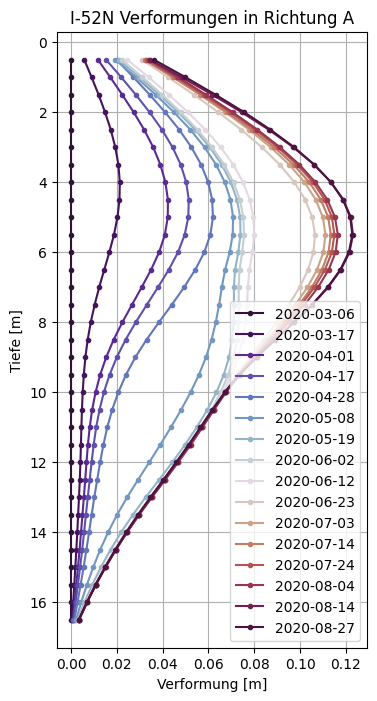

In [16]:
# Inclinometer I-52N, deformations in direction A


plt.figure(figsize=(4,8))
plt.title('I-52N Verformungen in Richtung A')

# We plot only every third measurement, because otherwise the graph is a little too crowded.

i=0
for my_date in dates_as_list[0::3]:
  c = cm.twilight_shifted(i/16.,1)
  df_1 = df.loc[(df.index == my_date) & (df['tube'] == 'I-52N'), :]
  legend_date = my_date.date()
  plt.plot(df_1['A_defo_relat'], df_1['depth'], color=c, marker='.', linestyle='-', label=legend_date)
  i+=1

plt.gca().invert_yaxis()
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Verformung [m]')
plt.ylabel('Tiefe [m]')
plt.legend()
plt.show()

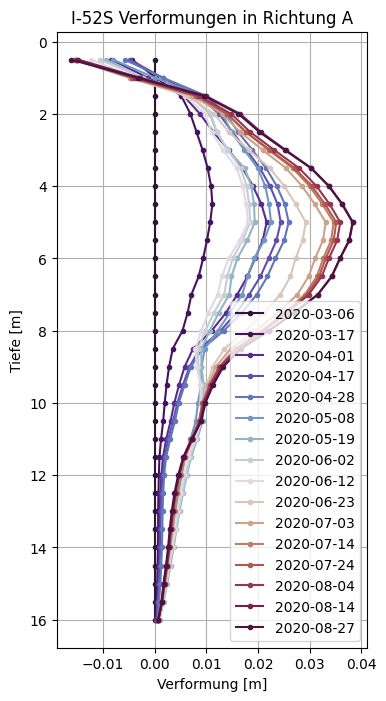

In [17]:
# Inclinometer I-52S, deformations in direction A


plt.figure(figsize=(4,8))
plt.title('I-52S Verformungen in Richtung A')

# We plot only every third measurement, because otherwise the graph is a little too crowded.

i=0
for my_date in dates_as_list[0::3]:
  c = cm.twilight_shifted(i/16.,1)
  df_1 = df.loc[(df.index == my_date) & (df['tube'] == 'I-52S'), :]
  legend_date = my_date.date()
  plt.plot(df_1['A_defo_relat'], df_1['depth'], color=c, marker='.', linestyle='-', label=legend_date)
  i+=1

plt.gca().invert_yaxis()
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Verformung [m]')
plt.ylabel('Tiefe [m]')
plt.legend()
plt.show()

## Transversale Verformung

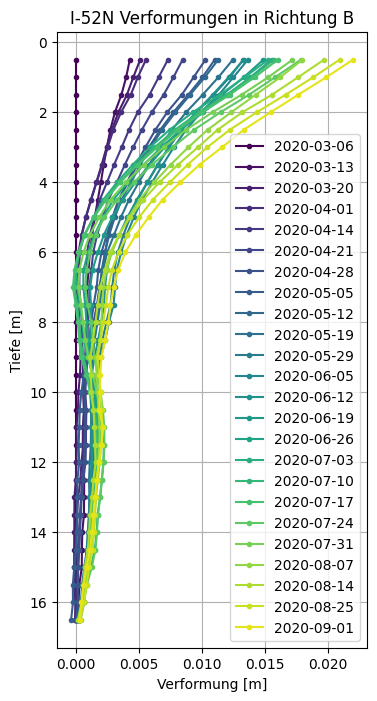

In [18]:
# Inclinometer I-52N, deformations in direction B


plt.figure(figsize=(4,8))
plt.title('I-52N Verformungen in Richtung B')

# We plot only every second measurement, because otherwise the graph is a little too crowded.

i=0
for my_date in dates_as_list[0::2]:
  c = cm.viridis(i/24.,1)
  df_1 = df.loc[(df.index == my_date) & (df['tube'] == 'I-52N'), :]
  legend_date = my_date.date()
  plt.plot(df_1['B_defo_relat'], df_1['depth'], color=c, marker='.', linestyle='-', label=legend_date)
  i+=1

plt.gca().invert_yaxis()
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Verformung [m]')
plt.ylabel('Tiefe [m]')
plt.legend()
plt.show()

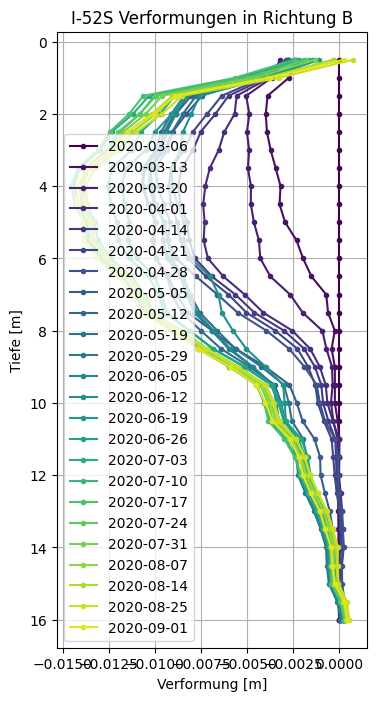

In [19]:
# Inclinometer I-52S, deformations in direction B


plt.figure(figsize=(4,8))
plt.title('I-52S Verformungen in Richtung B')

# We plot only every second measurement, because otherwise the graph is a little too crowded.

i=0
for my_date in dates_as_list[0::2]:
  c = cm.viridis(i/24.,1)
  df_1 = df.loc[(df.index == my_date) & (df['tube'] == 'I-52S'), :]
  legend_date = my_date.date()
  plt.plot(df_1['B_defo_relat'], df_1['depth'], color=c, marker='.', linestyle='-', label=legend_date)
  i+=1

plt.gca().invert_yaxis()
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Verformung [m]')
plt.ylabel('Tiefe [m]')
plt.legend()
plt.show()

**Erste Erkenntnisse:**

Die Verformungen im Inklino Nord und im Inklino Süd sind ganz klar nicht gleich, d.h. sie werden unterschiedlichen Werte der Abminderungsfaktoren liefern.

Könnte dieser Unterschied auf einer Baupiste (Auflast) zurückzuführen sein? Auf beiden Seiten der Spundwand waren Baumaschinen zum Einsatz, siehe dazu die Fotodokumentation.

# Auswertung der Spriesskräfte

Die gemessenen Spriesskräfte dienen ausschliesslich zur Kalibrierung des FE-Modells und fliessen nicht direkt in die Rückrechnung der Abminderungsfaktoren $\beta_D$ ein.

## Obere Spriesse K-50-1

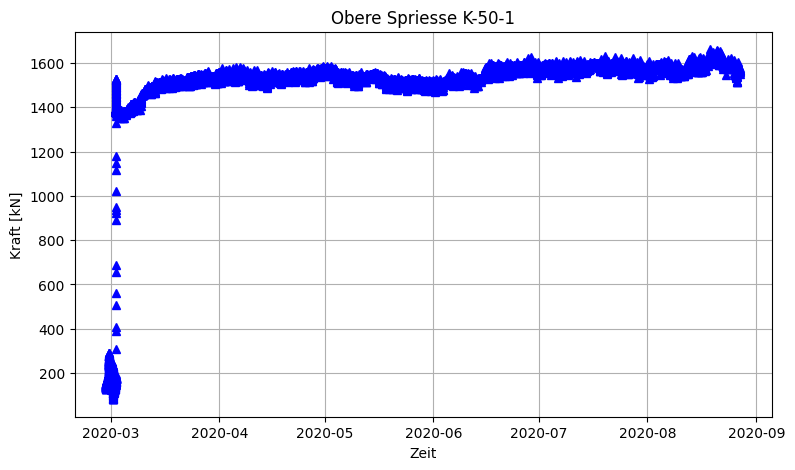

In [20]:
# Force over time, upper strut

plt.figure(figsize=(9,5))
plt.title('Obere Spriesse K-50-1')
plt.plot(df_spriesseO.Date_and_time, df_spriesseO.Kraft_Mittelwert, 'b^')

plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Zeit')
plt.ylabel('Kraft [kN]')
plt.show()

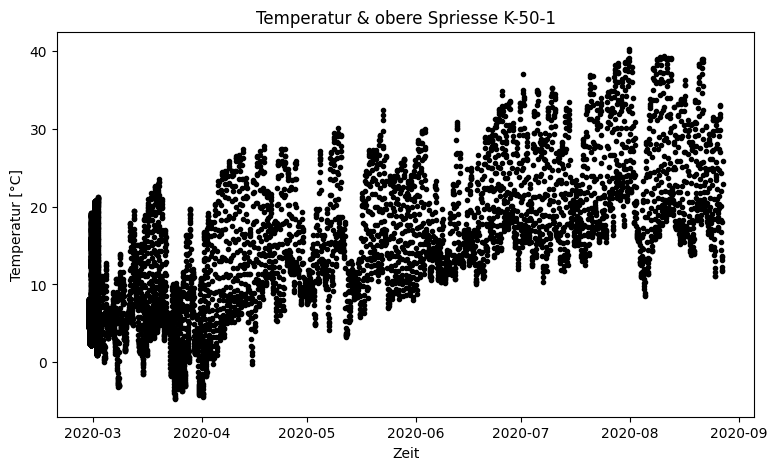

In [21]:
# plot temperature over time, upper strut

plt.figure(figsize=(9,5))
plt.title('Temperatur & obere Spriesse K-50-1')
plt.plot(df_spriesseO.Date_and_time, df_spriesseO.Temp_Mittelwert, 'k.')

plt.xlabel('Zeit')
plt.ylabel('Temperatur [°C]')
plt.show()

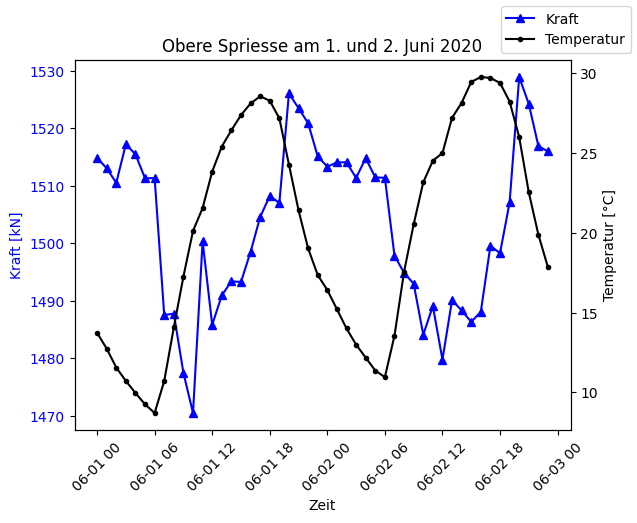

In [22]:
# As an example, let's plot the daily temperature change on the 1st and 2nd June 2020

# find the indexes with the following code line:
# df_spriesseO.loc[(df_spriesseO['Date_and_time'] >= datetime(2020, 6, 1, 0, 0, 0)) & (df_spriesseO['Date_and_time'] < datetime(2020, 6, 3, 0, 0, 0))]
# indexes 11414 - 11461 (included)

fig, ax1 = plt.subplots()

ax1.set_title('Obere Spriesse am 1. und 2. Juni 2020')

ax1.plot(df_spriesseO.Date_and_time[11414:11462], df_spriesseO.Kraft_Mittelwert[11414:11462], 'b^-', label='Kraft')
ax1.set_xlabel('Zeit')
ax1.set_ylabel('Kraft [kN]', color = 'blue')
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis ='y', labelcolor = 'blue')


# Adding twin axes
ax2 = ax1.twinx()

ax2.plot(df_spriesseO.Date_and_time[11414:11462], df_spriesseO.Temp_Mittelwert[11414:11462], 'k.-', label='Temperatur')
ax2.set_ylabel('Temperatur [°C]', color = 'k')
ax2.tick_params(axis ='y', labelcolor = 'k')
fig.legend()

fig.show()

## Untere Spriesse K-50-2

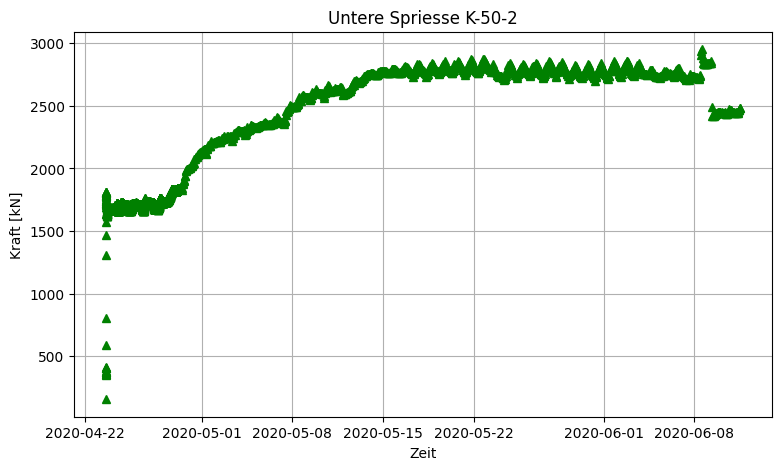

In [23]:
# Force over time, lower strut

plt.figure(figsize=(9,5))
plt.title('Untere Spriesse K-50-2')
plt.plot(df_spriesseU.Date_and_time, df_spriesseU.Kraft_Mittelwert, 'g^')

plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Zeit')
plt.ylabel('Kraft [kN]')
plt.show()

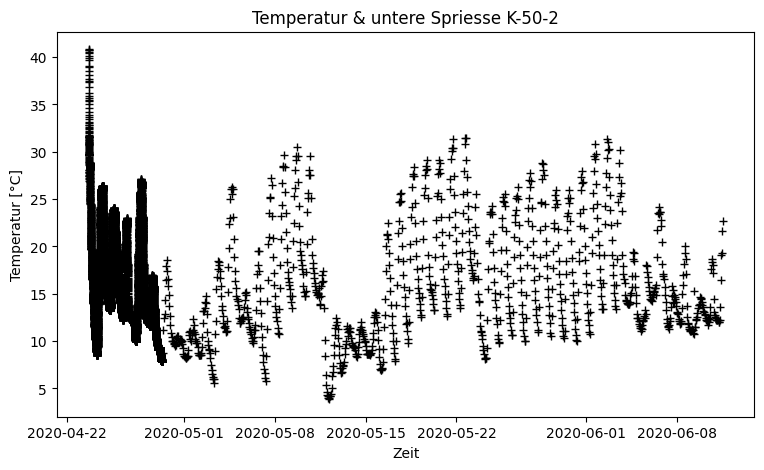

In [24]:
# temperature over time, lower strut

plt.figure(figsize=(9,5))
plt.title('Temperatur & untere Spriesse K-50-2')
plt.plot(df_spriesseU.Date_and_time, df_spriesseU.Temp_Mittelwert, 'k+')

plt.xlabel('Zeit')
plt.ylabel('Temperatur [°C]')
plt.show()

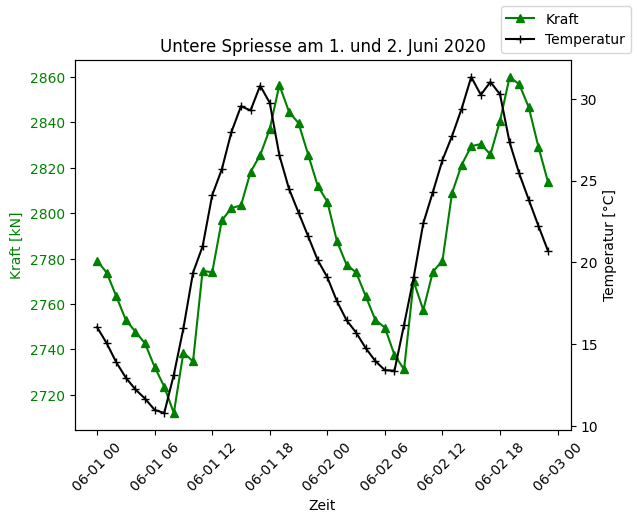

In [25]:
# As an example, let's plot the daily temperature change on the 1st and 2nd June 2020

# find the indexes with the following code line:
# df_spriesseU.loc[(df_spriesseU['Date_and_time'] >= datetime(2020, 6, 1, 0, 0, 0)) & (df_spriesseU['Date_and_time'] < datetime(2020, 6, 3, 0, 0, 0))]
# indexes: 8946 - 8993 (included)

fig, ax1 = plt.subplots()

ax1.set_title('Untere Spriesse am 1. und 2. Juni 2020')

ax1.plot(df_spriesseU.Date_and_time[8946:8994], df_spriesseU.Kraft_Mittelwert[8946:8994], 'g^-', label='Kraft')
ax1.set_xlabel('Zeit')
ax1.set_ylabel('Kraft [kN]', color = 'green')
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis ='y', labelcolor = 'green')


# Adding twin axes
ax2 = ax1.twinx()

ax2.plot(df_spriesseU.Date_and_time[8946:8994], df_spriesseU.Temp_Mittelwert[8946:8994], 'k+-', label='Temperatur')
ax2.set_ylabel('Temperatur [°C]', color = 'k')
ax2.tick_params(axis ='y', labelcolor = 'k')
fig.legend()

fig.show()

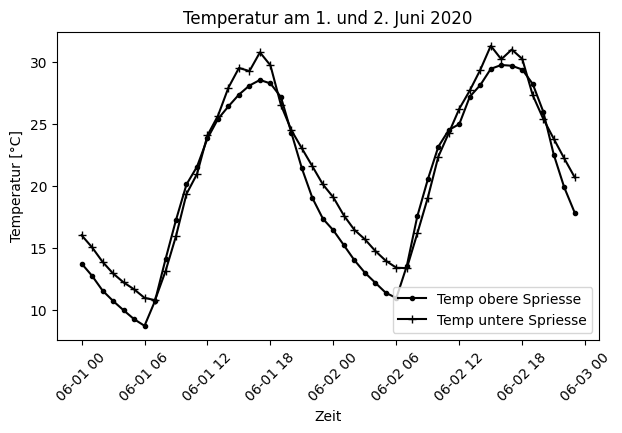

In [26]:
# plot both temperatures to see if they match
plt.figure(figsize=(7,4))
plt.title('Temperatur am 1. und 2. Juni 2020')

plt.plot(df_spriesseO.Date_and_time[11414:11462], df_spriesseO.Temp_Mittelwert[11414:11462], 'k.-', label='Temp obere Spriesse')
plt.plot(df_spriesseU.Date_and_time[8946:8994], df_spriesseU.Temp_Mittelwert[8946:8994], 'k+-', label='Temp untere Spriesse')

plt.tick_params(axis='x', rotation=45)
plt.xlabel('Zeit')
plt.ylabel('Temperatur [°C]')
plt.legend()
plt.show()

# By looking a the temperature plots, we can see tha the data matches our
# expectations:
# - the strut forces follow the course of the temperature (the upper strut
#   curve is a little wonky)
# - the temperatures measured at the upper and lower strut correspond very
#   well
# We can therefore confidently use these data to calibrate the Finite
# Element model in Paxis 2D.

## Spriesskräfte und Bauphasen

Aus dem Bauprogramm bzw. aus der Fotodokumentation lassen sich folgende Meilensteine erkennen:

*   17.03.2020: Aushubtiefe +542.22 m ü.M. im Block 51 erreicht. Der Einbau der unteren Spriessen erfolgt innerhalb von 3 Tagen. Der Block 52 (von Interesse für die vorliegende Datenauswertung) befindet sich gerade im Übergangsbereich zwischen Aushubtiefe +542.22 und +545.00 m ü.M.

*   20.03.2020: Aushubtiefe +542.22 m ü.M. auch im Block 52 erreicht, Installation untere Longarinen

*   keine Fotos vom 20.03. bis 06.04.2020: CoV19 Lockdown. Ist etwas gelaufen auf der Baustelle während dieser Zeit?  

*   07.04.2020: eine untere Spriesse im Block 52 ist installiert

*   ca. Mitte April 2020: alle untere Spriessen im Block 52 sind jetzt installiert

*   23.04.2020: Installation der unteren Spriessen ist bis zum Block 53 fortgeschritten

*   12.05.2020: Start Materialersatz auf der Baugrubensohle im Block 52

*   ca. 04.06.2020: die Betonplatte ist realisiert

*   10.-12.06.2020: Rückbau der unteren Spriessen im Block 52

*   ca. 01.07.2020: die Tunnelwände und -decke im Block 49 oder 50 sind fast fertig armiert.

*   12.08.2020: die Tunnelwände und -decke im Block 52 sind betoniert, Hinterfüllung steht noch aus

*   ab 18.08.2020: die Hinterfüllung wird in Angriff genommen



In [27]:
# create the data needed to plot the construction stages as vertical lines

aushub_fertig = datetime(2020, 3, 20, 0, 0, 0)
aushubx = [aushub_fertig, aushub_fertig]
aushuby = [100, 2900]

betonplatte_fertig = datetime(2020, 6, 4, 0, 0, 0)
betonplattex = [betonplatte_fertig, betonplatte_fertig]

hinterfuellung_fertig = datetime(2020, 8, 18, 0, 0, 0)
hinterfuellungx = [hinterfuellung_fertig, hinterfuellung_fertig]

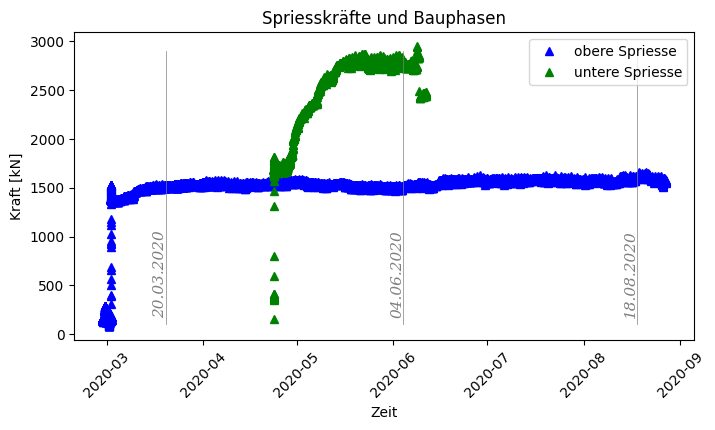

In [28]:
plt.figure(figsize=(8,4))
plt.title('Spriesskräfte und Bauphasen')

plt.plot(df_spriesseO.Date_and_time, df_spriesseO.Kraft_Mittelwert, 'b^', label='obere Spriesse')
plt.plot(df_spriesseU.Date_and_time, df_spriesseU.Kraft_Mittelwert, 'g^', label='untere Spriesse')

# plot construction stages
font_bauphasen = {'family': 'serif', 'color': 'grey' , 'size': 11, 'style': 'italic'}
plt.text(datetime(2020, 3, 16, 0, 0), 200, '20.03.2020', fontdict=font_bauphasen, rotation=90)
plt.plot(aushubx, aushuby, color='grey', linewidth=0.5)

plt.text(datetime(2020, 5, 31, 0, 0), 200, '04.06.2020', fontdict=font_bauphasen, rotation=90)
plt.plot(betonplattex, aushuby, color='grey', linewidth=0.5)

plt.text(datetime(2020, 8, 14, 0, 0), 200, '18.08.2020', fontdict=font_bauphasen, rotation=90)
plt.plot(hinterfuellungx, aushuby, color='grey', linewidth=0.5)

plt.tick_params(axis='x', rotation=45)
plt.xlabel('Zeit')
plt.ylabel('Kraft [kN]')
plt.legend()
plt.show()

## Wärmedehnung

In Plaxis-2D werden wir den Einfluss der Temperatur nicht modellieren. Aus diesem Grund müssen wir abklären, wie stark die Temperatur sich auf die Spriesskräfte auswirkt. Insbesondere bei der oberen Spriesse ist im Verlauf der Bauarbeiten eine Zunahme der durchschnittlichen Temperaturen zu beobachten, von ca. 10°C Ende Februar bis ca. 24°C im Sommer.

$\Delta F = A * E * \alpha_T * \Delta T $


In [29]:
# See also SIA-Norm 263 (2013), 3.2.2.


# Steel properties
E = 210*10**6           # Young's modulus in [kN/m2]
alpha_T = 10*(10**-6)   # temperature expansion coefficient [1/°C]

# strut properties
A = 0.017200            # cross-section surface of ROR 508x11 in [m2]
L0 = 12                 # initial length of the strut in [m]


delta_T = 14            # temperature change in [°C]


# temperature expansion
delta_L = L0*alpha_T*delta_T
print('lengthening = ' + str(round(delta_L, 5)) + ' m')
epsilon = delta_L/L0*100
print('lengthening = ' + str(round(epsilon,5)) + ' %')

# By how much does the strut force increase, if temperature expansion is fully inhibited?
delta_F = A*E*epsilon/100
print('force change = ' + str(round(delta_F,1)) + ' kN')

lengthening = 0.00168 m
lengthening = 0.014 %
force change = 505.7 kN


In Wirklichkeit ist die Wärmedehnung der Spriesse nicht kompett behindert, weil die Spundbohlen eine gewisse Flexibilität aufweisen. Es ist jedoch ersichtlich, dass die Temperatur einen erheblichen Einfluss auf die Spriesskräfte hat.
Wäre die Aussentemperatur während den Bauarbeiten konstant geblieben, hätten wir bei der oberen Spriesse wahrscheinlich eine maximale Kraft von $ \sim 1000 - 1200 kN $ erreicht (anstatt $1500 - 1600 kN$). Wir führen also die Kalibration unseres Plaxis-Modells mit diesem Wert durch.

# Vergleich zwischen Plaxis und Inklinometer

Als erstes müssen wir, für jede Phase aus Plaxis-2D, die entsprechende Inklinometermessung wählen. Die Rückrechnung des Abminderungsfaktors $\beta_D$ erfolgt dann aus dem Vergleich zwischen dem Momentenverlauf aus Plaxis-2D und die empirisch gemessene Wandverformung:

*   Phase 2: 25.03.2020
*   Phase 3: 17.04.2020
*   Phasen 4, 5 und 6: 15.05.2020
*   Phase 7: 16.06.2020

Die Wahl des massgebenden Datums für die Phasen 4, 5 und 6 ist mit Unsicherheit behaftet. Diese drei Phasen ergeben in Plaxis praktisch identischen Verformungen, obwohl die Bauarbeiten in Wirklichkeit ungefähr ein Monat, von Anfang Mai bis Anfang Juni 2020, gedauert haben. Es ist deswegen nicht a priori klar, welche Inklinometermessung in die Auswertung einfliessen soll. Die untenstehenden Diagramme liefern keine Hinweise dazu: Für die Spundwand Nord beobachtet man qualitativ (Form) eine gute Übereinstimmung, quantitativ (Betrag) jedoch nicht. Für die Spundwand Süd ist es genau umgekehrt, wobei keine qualitative Übereinstimmung vorkommt, betragsmässig sind die maximalen Verformungen aus Plaxis und aus den Inklinometern in der gleichen Grössenordnung.

In [30]:
# The Plaxis simulation phases 4, 5, and 6 yield identical wall deflections.
# The construction works corresponding to phases 4 to 6 span from the beginning of May to the beginning of June 2020.
dates_Phase4 = ['2020-05-01', '2020-05-08', '2020-05-12', '2020-05-19', '2020-05-29', '2020-06-05']

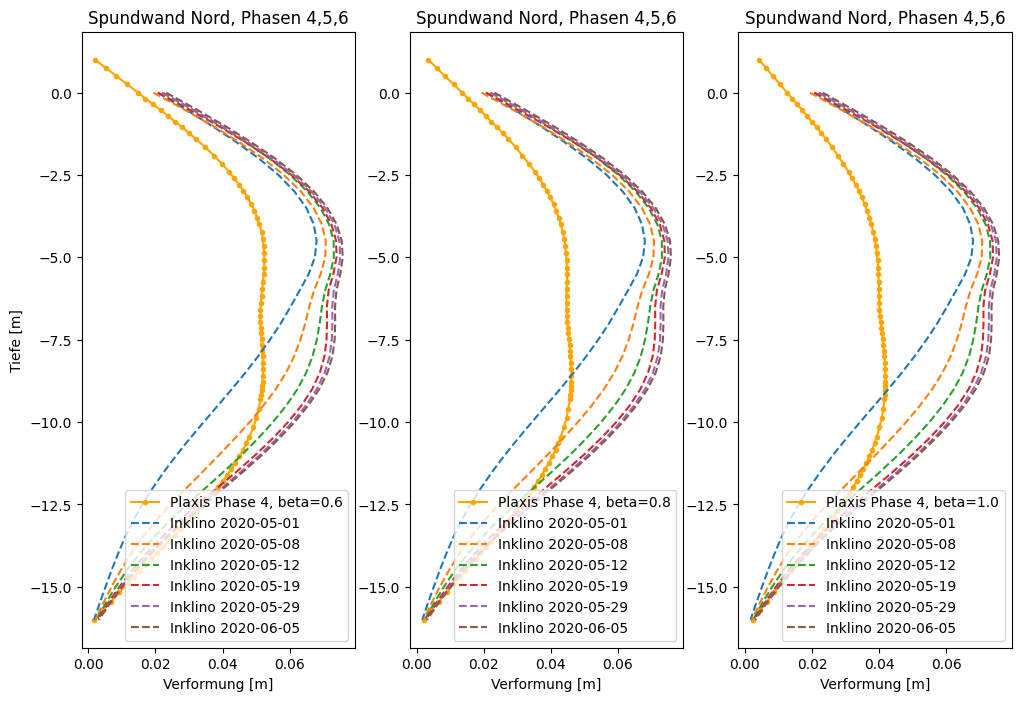

In [31]:
## Spundwand Nord ##
##    Phasen 4,5,6    ###

plt.figure(figsize=(12,8))

plt.subplot(1,3,1)
plt.title('Spundwand Nord, Phasen 4,5,6')
plt.plot(-df_plaxis_uN['Aushub_Phase4_[m]_06'], df_plaxis_uN['Y_coordinate_[m]_06'], color='orange', marker='.', linestyle='-', label='Plaxis Phase 4, beta=0.6')
for mydate in dates_Phase4:
  df_1 = df.loc[(df.index == mydate) & (df['tube'] == 'I-52N'), :]
  legend_1 = 'Inklino ' + str(mydate)
  plt.plot(df_1['A_defo_relat'], -df_1['depth']+0.5, linestyle='--', label=legend_1)
plt.legend()
plt.xlabel('Verformung [m]')
plt.ylabel('Tiefe [m]')


plt.subplot(1,3,2)
plt.title('Spundwand Nord, Phasen 4,5,6')
plt.plot(-df_plaxis_uN['Aushub_Phase4_[m]_08'], df_plaxis_uN['Y_coordinate_[m]_08'], color='orange', marker='.', linestyle='-', label='Plaxis Phase 4, beta=0.8')
for mydate in dates_Phase4:
  df_1 = df.loc[(df.index == mydate) & (df['tube'] == 'I-52N'), :]
  legend_1 = 'Inklino ' + str(mydate)
  plt.plot(df_1['A_defo_relat'], -df_1['depth']+0.5, linestyle='--', label=legend_1)
plt.legend()
plt.xlabel('Verformung [m]')


plt.subplot(1,3,3)
plt.title('Spundwand Nord, Phasen 4,5,6')
plt.plot(-df_plaxis_uN['Aushub_Phase4_[m]_10'], df_plaxis_uN['Y_coordinate_[m]_10'], color='orange', marker='.', linestyle='-', label='Plaxis Phase 4, beta=1.0')
for mydate in dates_Phase4:
  df_1 = df.loc[(df.index == mydate) & (df['tube'] == 'I-52N'), :]
  legend_1 = 'Inklino ' + str(mydate)
  plt.plot(df_1['A_defo_relat'], -df_1['depth']+0.5, linestyle='--', label=legend_1)
plt.xlabel('Verformung [m]')
plt.legend()


plt.show()

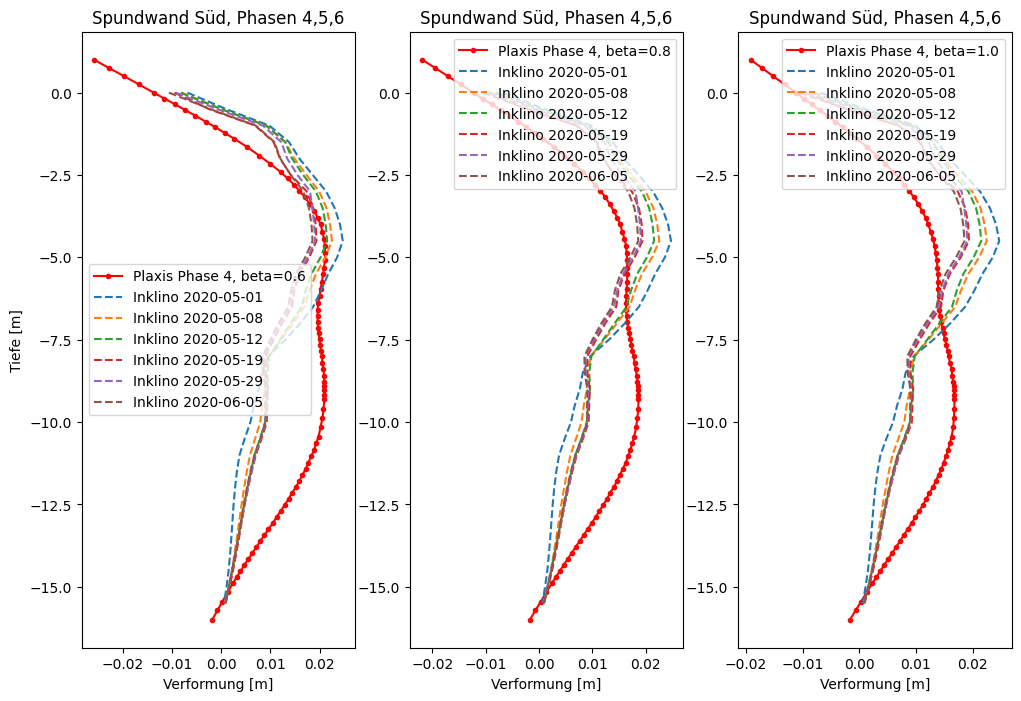

In [32]:
## Spundwand Süd ##
##   Phasen 4,5,6  ##

plt.figure(figsize=(12,8))

plt.subplot(1,3,1)
plt.title('Spundwand Süd, Phasen 4,5,6')
plt.plot(df_plaxis_uS['Aushub_Phase4_[m]_06'], df_plaxis_uS['Y_coordinate_[m]_06'], color='red', marker='.', linestyle='-', label='Plaxis Phase 4, beta=0.6')
for mydate in dates_Phase4:
  df_1 = df.loc[(df.index == mydate) & (df['tube'] == 'I-52S'), :]
  legend_1 = 'Inklino ' + str(mydate)
  plt.plot(df_1['A_defo_relat'], -df_1['depth']+0.5, linestyle='--', label=legend_1)
plt.legend()
plt.xlabel('Verformung [m]')
plt.ylabel('Tiefe [m]')


plt.subplot(1,3,2)
plt.title('Spundwand Süd, Phasen 4,5,6')
plt.plot(df_plaxis_uS['Aushub_Phase4_[m]_08'], df_plaxis_uS['Y_coordinate_[m]_08'], color='red', marker='.', linestyle='-', label='Plaxis Phase 4, beta=0.8')
for mydate in dates_Phase4:
  df_1 = df.loc[(df.index == mydate) & (df['tube'] == 'I-52S'), :]
  legend_1 = 'Inklino ' + str(mydate)
  plt.plot(df_1['A_defo_relat'], -df_1['depth']+0.5, linestyle='--', label=legend_1)
plt.legend()
plt.xlabel('Verformung [m]')


plt.subplot(1,3,3)
plt.title('Spundwand Süd, Phasen 4,5,6')
plt.plot(df_plaxis_uS['Aushub_Phase4_[m]_10'], df_plaxis_uS['Y_coordinate_[m]_10'], color='red', marker='.', linestyle='-', label='Plaxis Phase 4, beta=1.0')
for mydate in dates_Phase4:
  df_1 = df.loc[(df.index == mydate) & (df['tube'] == 'I-52S'), :]
  legend_1 = 'Inklino ' + str(mydate)
  plt.plot(df_1['A_defo_relat'], -df_1['depth']+0.5, linestyle='--', label=legend_1)
plt.xlabel('Verformung [m]')
plt.legend()


plt.show()

# Rückrechnung von $\beta_D$ basierend auf den Momenten aus Plaxis

## Vorbereitung der Inklinometerdaten

In [33]:
# Fit a polynom of 9th degree to the displacements (inclinometer data).
# Save the coefficients in a dataframe.

Retaining_wall = ['North', 'South']
coefficients = ['a9', 'a8', 'a7', 'a6', 'a5', 'a4', 'a3', 'a2', 'a1', 'a0']
Phase = ['Phase 2', 'Phase 3', 'Phase 4-5-6', 'Phase 7']

my_index = pd.MultiIndex.from_product([Retaining_wall, Phase], names=['Retaining_wall', 'Phase'])
df_coeff_inclino = pd.DataFrame(np.zeros([8, 10]), index=my_index, columns = coefficients)

#df_coeff_inclino

In [34]:
# Sheet pile wall North

df_N2 = df.loc[(df.index == '2020-03-25') & (df['tube'] == 'I-52N'), :]
df_N3 = df.loc[(df.index == '2020-04-17') & (df['tube'] == 'I-52N'), :]
df_N456 = df.loc[(df.index == '2020-05-15') & (df['tube'] == 'I-52N'), :]
df_N7 = df.loc[(df.index == '2020-06-16') & (df['tube'] == 'I-52N'), :]

df_coeff_inclino.loc[('North', 'Phase 2'), :] = np.polyfit(df_N2['depth'], df_N2['A_defo_relat'], 9)
df_coeff_inclino.loc[('North', 'Phase 3'), :] = np.polyfit(df_N3['depth'], df_N3['A_defo_relat'], 9)
df_coeff_inclino.loc[('North', 'Phase 4-5-6'), :] = np.polyfit(df_N456['depth'], df_N456['A_defo_relat'], 9)
df_coeff_inclino.loc[('North', 'Phase 7'), :] = np.polyfit(df_N7['depth'], df_N7['A_defo_relat'], 9)

# Sheet pile wall South

df_S2 = df.loc[(df.index == '2020-03-25') & (df['tube'] == 'I-52S'), :]
df_S3 = df.loc[(df.index == '2020-04-17') & (df['tube'] == 'I-52S'), :]
df_S456 = df.loc[(df.index == '2020-05-15') & (df['tube'] == 'I-52S'), :]
df_S7 = df.loc[(df.index == '2020-06-16') & (df['tube'] == 'I-52S'), :]

df_coeff_inclino.loc[('South', 'Phase 2'), :] = np.polyfit(df_S2['depth'], df_S2['A_defo_relat'], 9)
df_coeff_inclino.loc[('South', 'Phase 3'), :] = np.polyfit(df_S3['depth'], df_S3['A_defo_relat'], 9)
df_coeff_inclino.loc[('South', 'Phase 4-5-6'), :] = np.polyfit(df_S456['depth'], df_S456['A_defo_relat'], 9)
df_coeff_inclino.loc[('South', 'Phase 7'), :] = np.polyfit(df_S7['depth'], df_S7['A_defo_relat'], 9)

df_coeff_inclino

a9            a8            a7  \
Retaining_wall Phase                                                   
North          Phase 2      2.226248e-10 -2.171735e-08  8.731756e-07   
               Phase 3      6.500605e-12 -5.315513e-09  3.524502e-07   
               Phase 4-5-6  1.236944e-09 -9.500272e-08  3.023217e-06   
               Phase 7     -5.151141e-11 -6.078709e-11  1.437226e-07   
South          Phase 2      1.115771e-10 -1.414765e-08  6.687358e-07   
               Phase 3     -3.954549e-10  2.421748e-08 -5.499564e-07   
               Phase 4-5-6  4.829692e-10 -4.324949e-08  1.613645e-06   
               Phase 7     -3.726095e-11 -5.211630e-09  4.686669e-07   

                                  a6        a5        a4        a3        a2  \
Retaining_wall Phase                                                           
North          Phase 2     -0.000019  0.000228 -0.001581  0.005870 -0.011700   
               Phase 3     -0.000010  0.000136 -0.001007  0.003714 -0.007698   
               Phase 4-5-6 -0.000051  0.000501 -0.002804  0.008539 -0.014532   
               Phase 7     -0.000005  0.000079 -0.000599  0.002108 -0.004410   
South          Phase 2     -0.000016  0.000222 -0.001770  0.008121 -0.021487   
               Phase 3      0.000005  0.000005 -0.000418  0.003104 -0.011222   
               Phase 4-5-6 -0.000033  0.000389 -0.002805  0.012140 -0.031750   
               Phase 7     -0.000014  0.000226 -0.001990  0.010024 -0.029363   

                                  a1        a0  
Retaining_wall Phase                            
North          Phase 2      0.019883  0.001694  
               Phase 3      0.020547  0.006425  
               Phase 4-5-6  0.029132  0.011112  
               Phase 7      0.024094  0.015752  
South          Phase 2      0.036380 -0.020785  
               Phase 3      0.027224 -0.016222  
               Phase 4-5-6  0.052379 -0.029280  
               Phase 7      0.053502 -0.034410

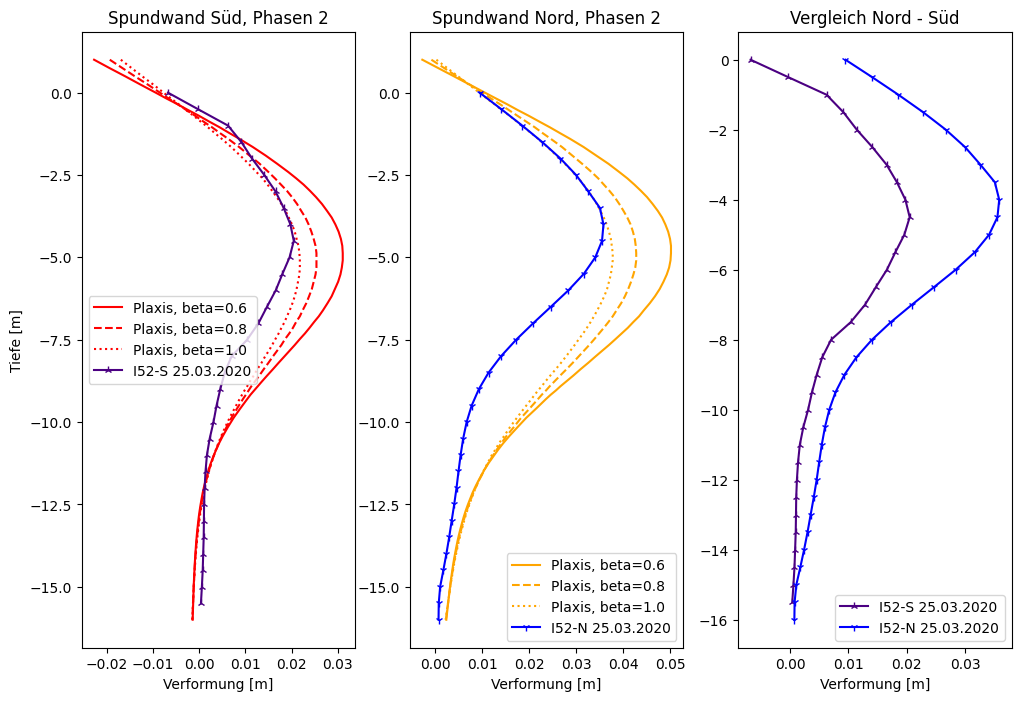

In [76]:
# Phase 2

plt.figure(figsize=(12,8))

plt.subplot(1,3,1)
plt.title('Spundwand Süd, Phasen 2')
plt.plot(df_plaxis_uS['Aushub_Phase2_[m]_06'], df_plaxis_uS['Y_coordinate_[m]_06'], color='red', marker='', linestyle='-', label='Plaxis, beta=0.6')
plt.plot(df_plaxis_uS['Aushub_Phase2_[m]_08'], df_plaxis_uS['Y_coordinate_[m]_08'], color='red', marker='', linestyle='--', label='Plaxis, beta=0.8')
plt.plot(df_plaxis_uS['Aushub_Phase2_[m]_10'], df_plaxis_uS['Y_coordinate_[m]_10'], color='red', marker='', linestyle=':', label='Plaxis, beta=1.0')
plt.plot(df_S2['A_defo_relat'], -df_S2['depth']+0.5, color='indigo', marker='2', linestyle='-', label='I52-S 25.03.2020')
plt.legend()
plt.xlabel('Verformung [m]')
plt.ylabel('Tiefe [m]')

plt.subplot(1,3,2)
plt.title('Spundwand Nord, Phasen 2')
plt.plot(-df_plaxis_uN['Aushub_Phase2_[m]_06'], df_plaxis_uN['Y_coordinate_[m]_06'], color='orange', marker='', linestyle='-', label='Plaxis, beta=0.6')
plt.plot(-df_plaxis_uN['Aushub_Phase2_[m]_08'], df_plaxis_uN['Y_coordinate_[m]_08'], color='orange', marker='', linestyle='--', label='Plaxis, beta=0.8')
plt.plot(-df_plaxis_uN['Aushub_Phase2_[m]_10'], df_plaxis_uN['Y_coordinate_[m]_10'], color='orange', marker='', linestyle=':', label='Plaxis, beta=1.0')
plt.plot(df_N2['A_defo_relat'], -df_N2['depth']+0.5, color='blue', marker='1', linestyle='-', label='I52-N 25.03.2020')
plt.legend()
plt.xlabel('Verformung [m]')

plt.subplot(1,3,3)
plt.title('Vergleich Nord - Süd')
plt.plot(df_S2['A_defo_relat'], -df_S2['depth']+0.5, color='indigo', marker='2', linestyle='-', label='I52-S 25.03.2020')
plt.plot(df_N2['A_defo_relat'], -df_N2['depth']+0.5, color='blue', marker='1', linestyle='-', label='I52-N 25.03.2020')
plt.legend()
plt.xlabel('Verformung [m]')

plt.show()

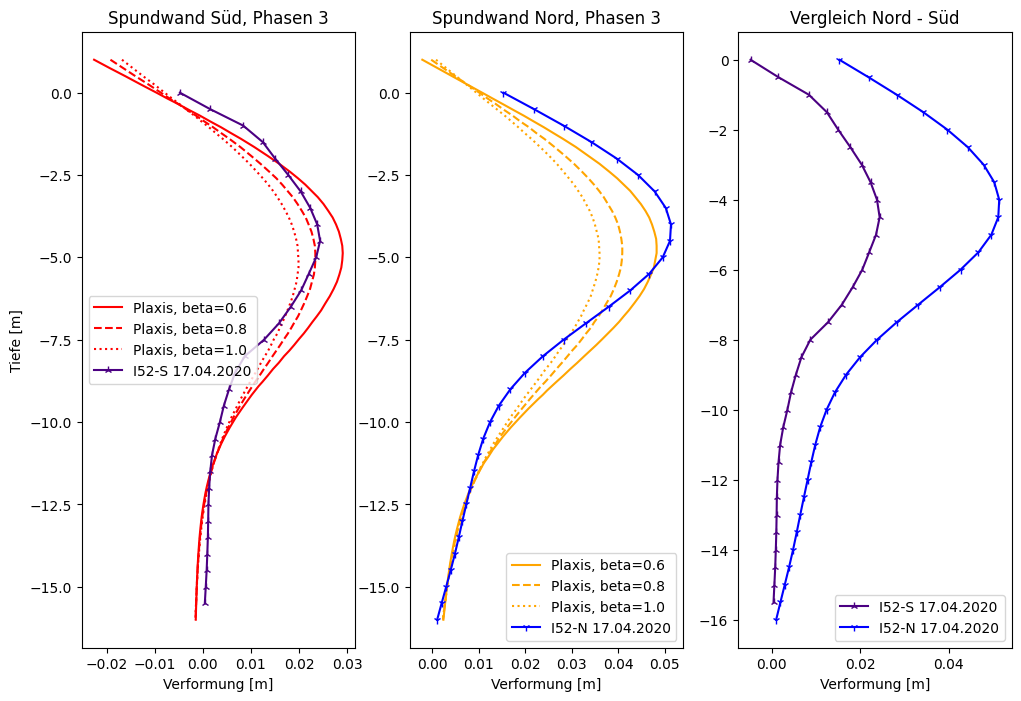

In [78]:
# Phase 3

plt.figure(figsize=(12,8))

plt.subplot(1,3,1)
plt.title('Spundwand Süd, Phasen 3')
plt.plot(df_plaxis_uS['untere_Spriesse_Phase3_[m]_06'], df_plaxis_uS['Y_coordinate_[m]_06'], color='red', marker='', linestyle='-', label='Plaxis, beta=0.6')
plt.plot(df_plaxis_uS['untere_Spriesse_Phase3_[m]_08'], df_plaxis_uS['Y_coordinate_[m]_08'], color='red', marker='', linestyle='--', label='Plaxis, beta=0.8')
plt.plot(df_plaxis_uS['untere_Spriesse_Phase3_[m]_10'], df_plaxis_uS['Y_coordinate_[m]_10'], color='red', marker='', linestyle=':', label='Plaxis, beta=1.0')
plt.plot(df_S3['A_defo_relat'], -df_S3['depth']+0.5, color='indigo', marker='2', linestyle='-', label='I52-S 17.04.2020')
plt.legend()
plt.xlabel('Verformung [m]')
plt.ylabel('Tiefe [m]')

plt.subplot(1,3,2)
plt.title('Spundwand Nord, Phasen 3')
plt.plot(-df_plaxis_uN['untere_Spriesse_Phase3_[m]_06'], df_plaxis_uN['Y_coordinate_[m]_06'], color='orange', marker='', linestyle='-', label='Plaxis, beta=0.6')
plt.plot(-df_plaxis_uN['untere_Spriesse_Phase3_[m]_08'], df_plaxis_uN['Y_coordinate_[m]_08'], color='orange', marker='', linestyle='--', label='Plaxis, beta=0.8')
plt.plot(-df_plaxis_uN['untere_Spriesse_Phase3_[m]_10'], df_plaxis_uN['Y_coordinate_[m]_10'], color='orange', marker='', linestyle=':', label='Plaxis, beta=1.0')
plt.plot(df_N3['A_defo_relat'], -df_N3['depth']+0.5, color='blue', marker='1', linestyle='-', label='I52-N 17.04.2020')
plt.legend()
plt.xlabel('Verformung [m]')

plt.subplot(1,3,3)
plt.title('Vergleich Nord - Süd')
plt.plot(df_S3['A_defo_relat'], -df_S3['depth']+0.5, color='indigo', marker='2', linestyle='-', label='I52-S 17.04.2020')
plt.plot(df_N3['A_defo_relat'], -df_N3['depth']+0.5, color='blue', marker='1', linestyle='-', label='I52-N 17.04.2020')
plt.legend()
plt.xlabel('Verformung [m]')

plt.show()

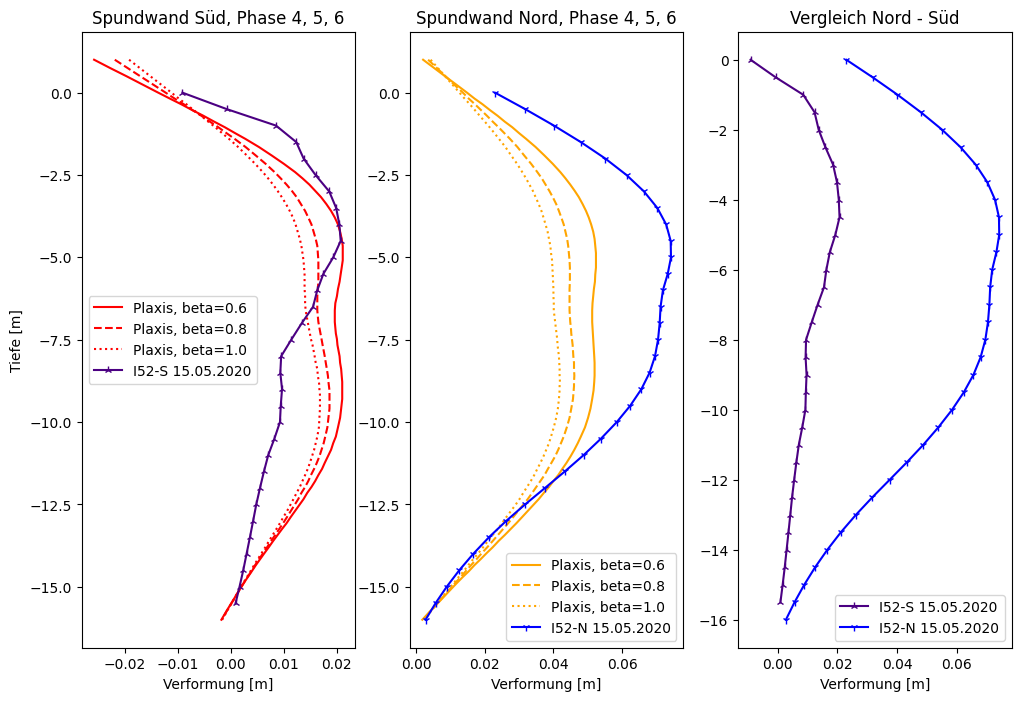

In [79]:
# Phase 4,5,6

plt.figure(figsize=(12,8))

plt.subplot(1,3,1)
plt.title('Spundwand Süd, Phase 4, 5, 6')
plt.plot(df_plaxis_uS['Aushub_Phase4_[m]_06'], df_plaxis_uS['Y_coordinate_[m]_06'], color='red', marker='', linestyle='-', label='Plaxis, beta=0.6')
plt.plot(df_plaxis_uS['Aushub_Phase4_[m]_08'], df_plaxis_uS['Y_coordinate_[m]_08'], color='red', marker='', linestyle='--', label='Plaxis, beta=0.8')
plt.plot(df_plaxis_uS['Aushub_Phase4_[m]_10'], df_plaxis_uS['Y_coordinate_[m]_10'], color='red', marker='', linestyle=':', label='Plaxis, beta=1.0')
plt.plot(df_S456['A_defo_relat'], -df_S456['depth']+0.5, color='indigo', marker='2', linestyle='-', label='I52-S 15.05.2020')
plt.legend()
plt.xlabel('Verformung [m]')
plt.ylabel('Tiefe [m]')

plt.subplot(1,3,2)
plt.title('Spundwand Nord, Phase 4, 5, 6')
plt.plot(-df_plaxis_uN['Aushub_Phase4_[m]_06'], df_plaxis_uN['Y_coordinate_[m]_06'], color='orange', marker='', linestyle='-', label='Plaxis, beta=0.6')
plt.plot(-df_plaxis_uN['Aushub_Phase4_[m]_08'], df_plaxis_uN['Y_coordinate_[m]_08'], color='orange', marker='', linestyle='--', label='Plaxis, beta=0.8')
plt.plot(-df_plaxis_uN['Aushub_Phase4_[m]_10'], df_plaxis_uN['Y_coordinate_[m]_10'], color='orange', marker='', linestyle=':', label='Plaxis, beta=1.0')
plt.plot(df_N456['A_defo_relat'], -df_N456['depth']+0.5, color='blue', marker='1', linestyle='-', label='I52-N 15.05.2020')
plt.legend()
plt.xlabel('Verformung [m]')

plt.subplot(1,3,3)
plt.title('Vergleich Nord - Süd')
plt.plot(df_S456['A_defo_relat'], -df_S456['depth']+0.5, color='indigo', marker='2', linestyle='-', label='I52-S 15.05.2020')
plt.plot(df_N456['A_defo_relat'], -df_N456['depth']+0.5, color='blue', marker='1', linestyle='-', label='I52-N 15.05.2020')
plt.legend()
plt.xlabel('Verformung [m]')

plt.show()

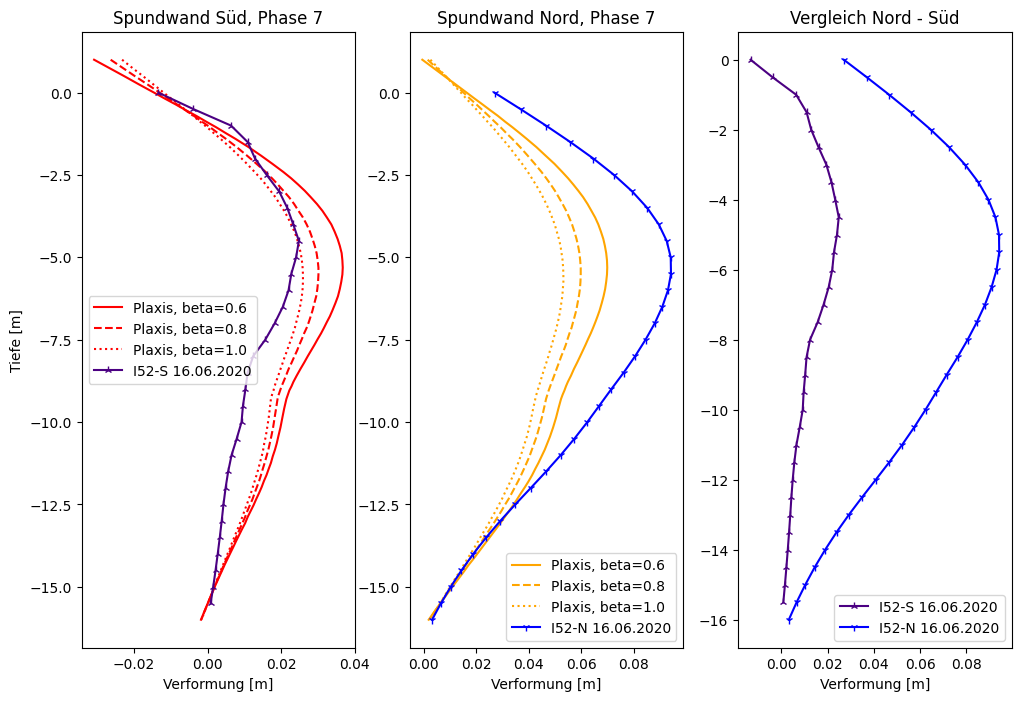

In [80]:
# Phase 7

plt.figure(figsize=(12,8))

plt.subplot(1,3,1)
plt.title('Spundwand Süd, Phase 7')
plt.plot(df_plaxis_uS['Rückbau_Spriesse_Phase7_[m]_06'], df_plaxis_uS['Y_coordinate_[m]_06'], color='red', marker='', linestyle='-', label='Plaxis, beta=0.6')
plt.plot(df_plaxis_uS['Rückbau_Spriesse_Phase7_[m]_08'], df_plaxis_uS['Y_coordinate_[m]_08'], color='red', marker='', linestyle='--', label='Plaxis, beta=0.8')
plt.plot(df_plaxis_uS['Rückbau_Spriesse_Phase7_[m]_10'], df_plaxis_uS['Y_coordinate_[m]_10'], color='red', marker='', linestyle=':', label='Plaxis, beta=1.0')
plt.plot(df_S7['A_defo_relat'], -df_S7['depth']+0.5, color='indigo', marker='2', linestyle='-', label='I52-S 16.06.2020')
plt.legend()
plt.xlabel('Verformung [m]')
plt.ylabel('Tiefe [m]')

plt.subplot(1,3,2)
plt.title('Spundwand Nord, Phase 7')
plt.plot(-df_plaxis_uN['Rückbau_Spriesse_Phase7_[m]_06'], df_plaxis_uN['Y_coordinate_[m]_06'], color='orange', marker='', linestyle='-', label='Plaxis, beta=0.6')
plt.plot(-df_plaxis_uN['Rückbau_Spriesse_Phase7_[m]_08'], df_plaxis_uN['Y_coordinate_[m]_08'], color='orange', marker='', linestyle='--', label='Plaxis, beta=0.8')
plt.plot(-df_plaxis_uN['Rückbau_Spriesse_Phase7_[m]_10'], df_plaxis_uN['Y_coordinate_[m]_10'], color='orange', marker='', linestyle=':', label='Plaxis, beta=1.0')
plt.plot(df_N7['A_defo_relat'], -df_N7['depth']+0.5, color='blue', marker='1', linestyle='-', label='I52-N 16.06.2020')
plt.legend()
plt.xlabel('Verformung [m]')

plt.subplot(1,3,3)
plt.title('Vergleich Nord - Süd')
plt.plot(df_S7['A_defo_relat'], -df_S7['depth']+0.5, color='indigo', marker='2', linestyle='-', label='I52-S 16.06.2020')
plt.plot(df_N7['A_defo_relat'], -df_N7['depth']+0.5, color='blue', marker='1', linestyle='-', label='I52-N 16.06.2020')
plt.legend()
plt.xlabel('Verformung [m]')

plt.show()

In [35]:
Y_coord = pd.Series(np.arange(0, -16.25, -0.25))  # y-coordinate [m] as in the Plaxis model
df_fit_inclino = pd.DataFrame(data = Y_coord, columns=['Y_coord'])
df_fit_inclino['depth'] = -Y_coord + 0.5                    # inclinometer depth


# w indicates displacement
# w1 indicates slope, the first derivative of w
# w2 indicates curvature, the second derivative of w


# calculate fitted values, North
df_fit_inclino['w_N2'] = np.polyval(df_coeff_inclino.loc[('North', 'Phase 2'), :], df_fit_inclino['depth'])
df_fit_inclino['w_N3'] = np.polyval(df_coeff_inclino.loc[('North', 'Phase 3'), :], df_fit_inclino['depth'])
df_fit_inclino['w_N456'] = np.polyval(df_coeff_inclino.loc[('North', 'Phase 4-5-6'), :], df_fit_inclino['depth'])
df_fit_inclino['w_N7'] = np.polyval(df_coeff_inclino.loc[('North', 'Phase 7'), :], df_fit_inclino['depth'])

# calculate fitted values, South
df_fit_inclino['w_S2'] = np.polyval(df_coeff_inclino.loc[('South', 'Phase 2'), :], df_fit_inclino['depth'])
df_fit_inclino['w_S3'] = np.polyval(df_coeff_inclino.loc[('South', 'Phase 3'), :], df_fit_inclino['depth'])
df_fit_inclino['w_S456'] = np.polyval(df_coeff_inclino.loc[('South', 'Phase 4-5-6'), :], df_fit_inclino['depth'])
df_fit_inclino['w_S7'] = np.polyval(df_coeff_inclino.loc[('South', 'Phase 7'), :], df_fit_inclino['depth'])

df_fit_inclino.head(5)

,Y_coord,depth,w_N2,w_N3,w_N456,w_N7,w_S2,w_S3,w_S456,w_S7
0,0.00,0.50,0.009352,0.015179,0.022952,0.026925,-0.007055,-0.005054,-0.009674,-0.013864
1,-0.25,0.75,0.012052,0.018784,0.027613,0.032060,-0.002671,-0.000938,-0.003535,-0.007149
2,-0.50,1.00,0.014376,0.022107,0.031901,0.037019,0.000665,0.002475,0.001042,-0.002024
3,-0.75,1.25,0.016501,0.025255,0.036002,0.041856,0.003275,0.005346,0.004517,0.001946
4,-1.00,1.50,0.018535,0.028289,0.040011,0.046596,0.005398,0.007809,0.007233,0.005094


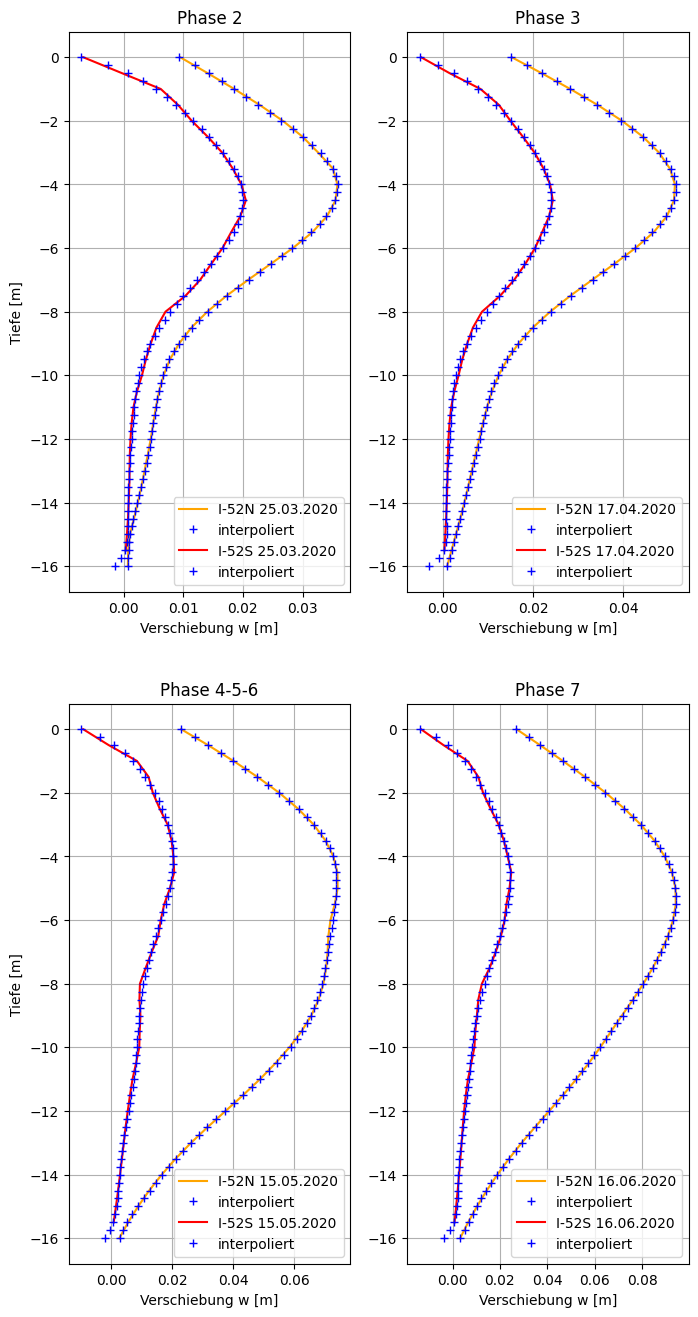

In [36]:
plt.figure(figsize=(8,16))

plt.subplot(2,2,1)
plt.title('Phase 2')
plt.plot(df_N2['A_defo_relat'], -df_N2['depth']+0.5, color='orange', linestyle='-', label='I-52N 25.03.2020')
plt.plot(df_fit_inclino['w_N2'], df_fit_inclino['Y_coord'], 'b+', label = 'interpoliert')
plt.plot(df_S2['A_defo_relat'], -df_S2['depth']+0.5, color='red', linestyle='-', label='I-52S 25.03.2020')
plt.plot(df_fit_inclino['w_S2'], df_fit_inclino['Y_coord'], 'b+', label = 'interpoliert')
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Verschiebung w [m]')
plt.ylabel('Tiefe [m]')
plt.legend()

plt.subplot(2,2,2)
plt.title('Phase 3')
plt.plot(df_N3['A_defo_relat'], -df_N3['depth']+0.5, color='orange', linestyle='-', label='I-52N 17.04.2020')
plt.plot(df_fit_inclino['w_N3'], df_fit_inclino['Y_coord'], 'b+', label = 'interpoliert')
plt.plot(df_S3['A_defo_relat'], -df_S3['depth']+0.5, color='red', linestyle='-', label='I-52S 17.04.2020')
plt.plot(df_fit_inclino['w_S3'], df_fit_inclino['Y_coord'], 'b+', label = 'interpoliert')
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Verschiebung w [m]')
plt.legend()

plt.subplot(2,2,3)
plt.title('Phase 4-5-6')
plt.plot(df_N456['A_defo_relat'], -df_N456['depth']+0.5, color='orange', linestyle='-', label='I-52N 15.05.2020')
plt.plot(df_fit_inclino['w_N456'], df_fit_inclino['Y_coord'], 'b+', label = 'interpoliert')
plt.plot(df_S456['A_defo_relat'], -df_S456['depth']+0.5, color='red', linestyle='-', label='I-52S 15.05.2020')
plt.plot(df_fit_inclino['w_S456'], df_fit_inclino['Y_coord'], 'b+', label = 'interpoliert')
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Verschiebung w [m]')
plt.ylabel('Tiefe [m]')
plt.legend()

plt.subplot(2,2,4)
plt.title('Phase 7')
plt.plot(df_N7['A_defo_relat'], -df_N7['depth']+0.5, color='orange', linestyle='-', label='I-52N 16.06.2020')
plt.plot(df_fit_inclino['w_N7'], df_fit_inclino['Y_coord'], 'b+', label = 'interpoliert')
plt.plot(df_S7['A_defo_relat'], -df_S7['depth']+0.5, color='red', linestyle='-', label='I-52S 16.06.2020')
plt.plot(df_fit_inclino['w_S7'], df_fit_inclino['Y_coord'], 'b+', label = 'interpoliert')
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Verschiebung w [m]')
plt.legend()

plt.show()

In [37]:
# w indicates displacement
# w1 indicates slope, the first derivative of w
# w2 indicates curvature, the second derivative of w


# w1
for index, row in df_fit_inclino.iterrows():
  if index == 0 or index == 64:
    df_fit_inclino.at[index, 'w1_N2'] = np.nan
    df_fit_inclino.at[index, 'w1_N3'] = np.nan
    df_fit_inclino.at[index, 'w1_N456'] = np.nan
    df_fit_inclino.at[index, 'w1_N7'] = np.nan
    df_fit_inclino.at[index, 'w1_S2'] = np.nan
    df_fit_inclino.at[index, 'w1_S3'] = np.nan
    df_fit_inclino.at[index, 'w1_S456'] = np.nan
    df_fit_inclino.at[index, 'w1_S7'] = np.nan
  else:
    df_fit_inclino.at[index, 'w1_N2'] = (df_fit_inclino.at[(index+1), 'w_N2'] - df_fit_inclino.at[(index-1), 'w_N2']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w1_N3'] = (df_fit_inclino.at[(index+1), 'w_N3'] - df_fit_inclino.at[(index-1), 'w_N3']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w1_N456'] = (df_fit_inclino.at[(index+1), 'w_N456'] - df_fit_inclino.at[(index-1), 'w_N456']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w1_N7'] = (df_fit_inclino.at[(index+1), 'w_N7'] - df_fit_inclino.at[(index-1), 'w_N7']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w1_S2'] = (df_fit_inclino.at[(index+1), 'w_S2'] - df_fit_inclino.at[(index-1), 'w_S2']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w1_S3'] = (df_fit_inclino.at[(index+1), 'w_S3'] - df_fit_inclino.at[(index-1), 'w_S3']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w1_S456'] = (df_fit_inclino.at[(index+1), 'w_S456'] - df_fit_inclino.at[(index-1), 'w_S456']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w1_S7'] = (df_fit_inclino.at[(index+1), 'w_S7'] - df_fit_inclino.at[(index-1), 'w_S7']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])

# w2
for index, row in df_fit_inclino.iterrows():
  if index <= 1 or index >= 63:
    df_fit_inclino.at[index, 'w2_N2'] = np.nan
    df_fit_inclino.at[index, 'w2_N3'] = np.nan
    df_fit_inclino.at[index, 'w2_N456'] = np.nan
    df_fit_inclino.at[index, 'w2_N7'] = np.nan
    df_fit_inclino.at[index, 'w2_S2'] = np.nan
    df_fit_inclino.at[index, 'w2_S3'] = np.nan
    df_fit_inclino.at[index, 'w2_S456'] = np.nan
    df_fit_inclino.at[index, 'w2_S7'] = np.nan
  else:
    df_fit_inclino.at[index, 'w2_N2'] = (df_fit_inclino.at[(index+1), 'w1_N2'] - df_fit_inclino.at[(index-1), 'w1_N2']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w2_N3'] = (df_fit_inclino.at[(index+1), 'w1_N3'] - df_fit_inclino.at[(index-1), 'w1_N3']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w2_N456'] = (df_fit_inclino.at[(index+1), 'w1_N456'] - df_fit_inclino.at[(index-1), 'w1_N456']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w2_N7'] = (df_fit_inclino.at[(index+1), 'w1_N7'] - df_fit_inclino.at[(index-1), 'w1_N7']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w2_S2'] = (df_fit_inclino.at[(index+1), 'w1_S2'] - df_fit_inclino.at[(index-1), 'w1_S2']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w2_S3'] = (df_fit_inclino.at[(index+1), 'w1_S3'] - df_fit_inclino.at[(index-1), 'w1_S3']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w2_S456'] = (df_fit_inclino.at[(index+1), 'w1_S456'] - df_fit_inclino.at[(index-1), 'w1_S456']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])
    df_fit_inclino.at[index, 'w2_S7'] = (df_fit_inclino.at[(index+1), 'w1_S7'] - df_fit_inclino.at[(index-1), 'w1_S7']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])

#df_fit_inclino

## Vorbereiten der Momenten aus Plaxis

Der Momentenverlauf in den VL607 Profilen wurde mit Plaxis-2D berechnet. Um eine solche Simulation durchzuführen, muss der Anwender einen Wert der Steifigkeit eingeben, welcher den Abimnderungsfaktor $\beta_D$ berücksichtigt.

Der Momentenverlauf wird mit einem **Polynom 7. Grades** interpoliert.

## Spundwand Nord

In [38]:
# For the Northern sheet pile wall, we have to "mirror" the moment distribution to match the inclinometers measurements.
my_betas = ['_06', '_08', '_10']
my_phases = ['Aushub_Phase2_[kNm/m]', 'untere_Spriesse_Phase3_[kNm/m]',
             'Aushub_Phase4_[kNm/m]', 'Materialersatz_Phase5_[kNm/m]',
             'Bodenplatte_Phase6_[kNm/m]', 'Rückbau_Spriesse_Phase7_[kNm/m]',
             'Spundwand_realisieren_Phase1_[kNm/m]']
for my_beta in my_betas:
  for my_phase in my_phases:
    col_name = my_phase + my_beta
    df_plaxis_MN[col_name] = -1*df_plaxis_MN[col_name]

#df_plaxis_MN.head(5)

In [39]:
# Fit a polynom of 7th degree to the moments (obtained from Plaxis).
# Save the coefficients in a dataframe.

Retaining_wall = ['North', 'South']
Phase = ['Phase 2', 'Phase 3', 'Phase 4-5-6', 'Phase 7']
reduction_factor = ['beta_06', 'beta_08', 'beta_10']
coefficients = ['a7', 'a6', 'a5', 'a4', 'a3', 'a2', 'a1', 'a0']

my_index = pd.MultiIndex.from_product([Retaining_wall, Phase, reduction_factor], names=['Retaining_wall', 'Phase', 'Reduction_factor'])
df_coeff_moment = pd.DataFrame(np.zeros([24, 8]), index=my_index, columns = coefficients)

#df_coeff_moment

In [40]:
# Sheet pile wall North

df_coeff_moment.loc[('North', 'Phase 2', 'beta_06'), :] = np.polyfit(df_plaxis_MN['Y_coordinate_[m]_06'], df_plaxis_MN['Aushub_Phase2_[kNm/m]_06'], 7)
df_coeff_moment.loc[('North', 'Phase 2', 'beta_08'), :] = np.polyfit(df_plaxis_MN['Y_coordinate_[m]_08'], df_plaxis_MN['Aushub_Phase2_[kNm/m]_08'], 7)
df_coeff_moment.loc[('North', 'Phase 2', 'beta_10'), :] = np.polyfit(df_plaxis_MN['Y_coordinate_[m]_10'], df_plaxis_MN['Aushub_Phase2_[kNm/m]_10'], 7)
df_coeff_moment.loc[('North', 'Phase 3', 'beta_06'), :] = np.polyfit(df_plaxis_MN['Y_coordinate_[m]_06'], df_plaxis_MN['untere_Spriesse_Phase3_[kNm/m]_06'], 7)
df_coeff_moment.loc[('North', 'Phase 3', 'beta_08'), :] = np.polyfit(df_plaxis_MN['Y_coordinate_[m]_08'], df_plaxis_MN['untere_Spriesse_Phase3_[kNm/m]_08'], 7)
df_coeff_moment.loc[('North', 'Phase 3', 'beta_10'), :] = np.polyfit(df_plaxis_MN['Y_coordinate_[m]_10'], df_plaxis_MN['untere_Spriesse_Phase3_[kNm/m]_10'], 7)
df_coeff_moment.loc[('North', 'Phase 4-5-6', 'beta_06'), :] = np.polyfit(df_plaxis_MN['Y_coordinate_[m]_06'], df_plaxis_MN['Aushub_Phase4_[kNm/m]_06'], 7)
df_coeff_moment.loc[('North', 'Phase 4-5-6', 'beta_08'), :] = np.polyfit(df_plaxis_MN['Y_coordinate_[m]_08'], df_plaxis_MN['Aushub_Phase4_[kNm/m]_08'], 7)
df_coeff_moment.loc[('North', 'Phase 4-5-6', 'beta_10'), :] = np.polyfit(df_plaxis_MN['Y_coordinate_[m]_10'], df_plaxis_MN['Aushub_Phase4_[kNm/m]_10'], 7)
df_coeff_moment.loc[('North', 'Phase 7', 'beta_06'), :] = np.polyfit(df_plaxis_MN['Y_coordinate_[m]_06'], df_plaxis_MN['Rückbau_Spriesse_Phase7_[kNm/m]_06'], 7)
df_coeff_moment.loc[('North', 'Phase 7', 'beta_08'), :] = np.polyfit(df_plaxis_MN['Y_coordinate_[m]_08'], df_plaxis_MN['Rückbau_Spriesse_Phase7_[kNm/m]_08'], 7)
df_coeff_moment.loc[('North', 'Phase 7', 'beta_10'), :] = np.polyfit(df_plaxis_MN['Y_coordinate_[m]_10'], df_plaxis_MN['Rückbau_Spriesse_Phase7_[kNm/m]_10'], 7)

df_coeff_moment

a7        a6        a5  \
Retaining_wall Phase       Reduction_factor                                 
North          Phase 2     beta_06          -0.000244 -0.012108 -0.197501   
                           beta_08          -0.000223 -0.011231 -0.184070   
                           beta_10          -0.000217 -0.011020 -0.182348   
               Phase 3     beta_06          -0.000076 -0.002816 -0.001087   
                           beta_08          -0.000048 -0.001495  0.022052   
                           beta_10          -0.000038 -0.001075  0.028729   
               Phase 4-5-6 beta_06           0.001149  0.069913  1.630305   
                           beta_08           0.001173  0.071196  1.654747   
                           beta_10           0.001189  0.072046  1.670695   
               Phase 7     beta_06          -0.001154 -0.051768 -0.806544   
                           beta_08          -0.001235 -0.056023 -0.890661   
                           beta_10          -0.001296 -0.059258 -0.955050   
South          Phase 2     beta_06           0.000000  0.000000  0.000000   
                           beta_08           0.000000  0.000000  0.000000   
                           beta_10           0.000000  0.000000  0.000000   
               Phase 3     beta_06           0.000000  0.000000  0.000000   
                           beta_08           0.000000  0.000000  0.000000   
                           beta_10           0.000000  0.000000  0.000000   
               Phase 4-5-6 beta_06           0.000000  0.000000  0.000000   
                           beta_08           0.000000  0.000000  0.000000   
                           beta_10           0.000000  0.000000  0.000000   
               Phase 7     beta_06           0.000000  0.000000  0.000000   
                           beta_08           0.000000  0.000000  0.000000   
                           beta_10           0.000000  0.000000  0.000000   

                                                    a4         a3          a2  \
Retaining_wall Phase       Reduction_factor                                     
North          Phase 2     beta_06           -0.870544   4.846493   23.596541   
                           beta_08           -0.771625   5.394938   25.738625   
                           beta_10           -0.768643   5.550859   27.166724   
               Phase 3     beta_06            1.077089  13.604203   36.583323   
                           beta_08            1.271265  14.534329   39.064050   
                           beta_10            1.325406  14.895199   40.660081   
               Phase 4-5-6 beta_06           17.976007  91.150714  148.724144   
                           beta_08           18.167004  91.611193  148.793799   
                           beta_10           18.284809  91.822508  148.649423   
               Phase 7     beta_06           -4.666883  -2.506339   27.439430   
                           beta_08           -5.423582  -5.354533   25.257996   
                           beta_10           -6.003978  -7.512662   23.806505   
South          Phase 2     beta_06            0.000000   0.000000    0.000000   
                           beta_08            0.000000   0.000000    0.000000   
                           beta_10            0.000000   0.000000    0.000000   
               Phase 3     beta_06            0.000000   0.000000    0.000000   
                           beta_08            0.000000   0.000000    0.000000   
                           beta_10            0.000000   0.000000    0.000000   
               Phase 4-5-6 beta_06            0.000000   0.000000    0.000000   
                           beta_08            0.000000   0.000000    0.000000   
                           beta_10            0.000000   0.000000    0.000000   
               Phase 7     beta_06            0.000000   0.000000    0.000000   
                           beta_08            0.000000   0.000000    0.000000   
                       

In [41]:
# Sheet pile wall North
# Let's construct a multi-index dataframe where we are going to save all of our calculation results.

Phase = ['Phase 2', 'Phase 3', 'Phase 4-5-6', 'Phase 7']
reduction_factor = ['beta_06', 'beta_08', 'beta_10']   # these are the reduction factors used in the Plaxis simulations
Y_coord = Y_coord
back_calculation = ['moment_M', 'stiffness_EI', 'beta'] # we aim at back calculationg beta

my_index = pd.MultiIndex.from_product([Phase, reduction_factor, back_calculation], names=['phase', 'reduction factor', 'back calculation'])

# BC means back calculation
# N means North

df_BC_N = pd.DataFrame(np.zeros([36, 65]), index=my_index, columns = Y_coord)
df_BC_N = df_BC_N.T
#df_BC_N

In [42]:
# interpolation of the moment obtained with Plaxis-2D by a polynomial
# North

df_BC_N.loc[:, ('Phase 2', 'beta_06', 'moment_M')] = np.polyval(df_coeff_moment.loc[('North', 'Phase 2', 'beta_06'), :], Y_coord)
df_BC_N.loc[:, ('Phase 2', 'beta_08', 'moment_M')] = np.polyval(df_coeff_moment.loc[('North', 'Phase 2', 'beta_08'), :], Y_coord)
df_BC_N.loc[:, ('Phase 2', 'beta_10', 'moment_M')] = np.polyval(df_coeff_moment.loc[('North', 'Phase 2', 'beta_10'), :], Y_coord)

df_BC_N.loc[:, ('Phase 3', 'beta_06', 'moment_M')] = np.polyval(df_coeff_moment.loc[('North', 'Phase 3', 'beta_06'), :], Y_coord)
df_BC_N.loc[:, ('Phase 3', 'beta_08', 'moment_M')] = np.polyval(df_coeff_moment.loc[('North', 'Phase 3', 'beta_08'), :], Y_coord)
df_BC_N.loc[:, ('Phase 3', 'beta_10', 'moment_M')] = np.polyval(df_coeff_moment.loc[('North', 'Phase 3', 'beta_10'), :], Y_coord)

df_BC_N.loc[:, ('Phase 4-5-6', 'beta_06', 'moment_M')] = np.polyval(df_coeff_moment.loc[('North', 'Phase 4-5-6', 'beta_06'), :], Y_coord)
df_BC_N.loc[:, ('Phase 4-5-6', 'beta_08', 'moment_M')] = np.polyval(df_coeff_moment.loc[('North', 'Phase 4-5-6', 'beta_08'), :], Y_coord)
df_BC_N.loc[:, ('Phase 4-5-6', 'beta_10', 'moment_M')] = np.polyval(df_coeff_moment.loc[('North', 'Phase 4-5-6', 'beta_10'), :], Y_coord)

df_BC_N.loc[:, ('Phase 7', 'beta_06', 'moment_M')] = np.polyval(df_coeff_moment.loc[('North', 'Phase 7', 'beta_06'), :], Y_coord)
df_BC_N.loc[:, ('Phase 7', 'beta_08', 'moment_M')] = np.polyval(df_coeff_moment.loc[('North', 'Phase 7', 'beta_08'), :], Y_coord)
df_BC_N.loc[:, ('Phase 7', 'beta_10', 'moment_M')] = np.polyval(df_coeff_moment.loc[('North', 'Phase 7', 'beta_10'), :], Y_coord)

#df_BC_N

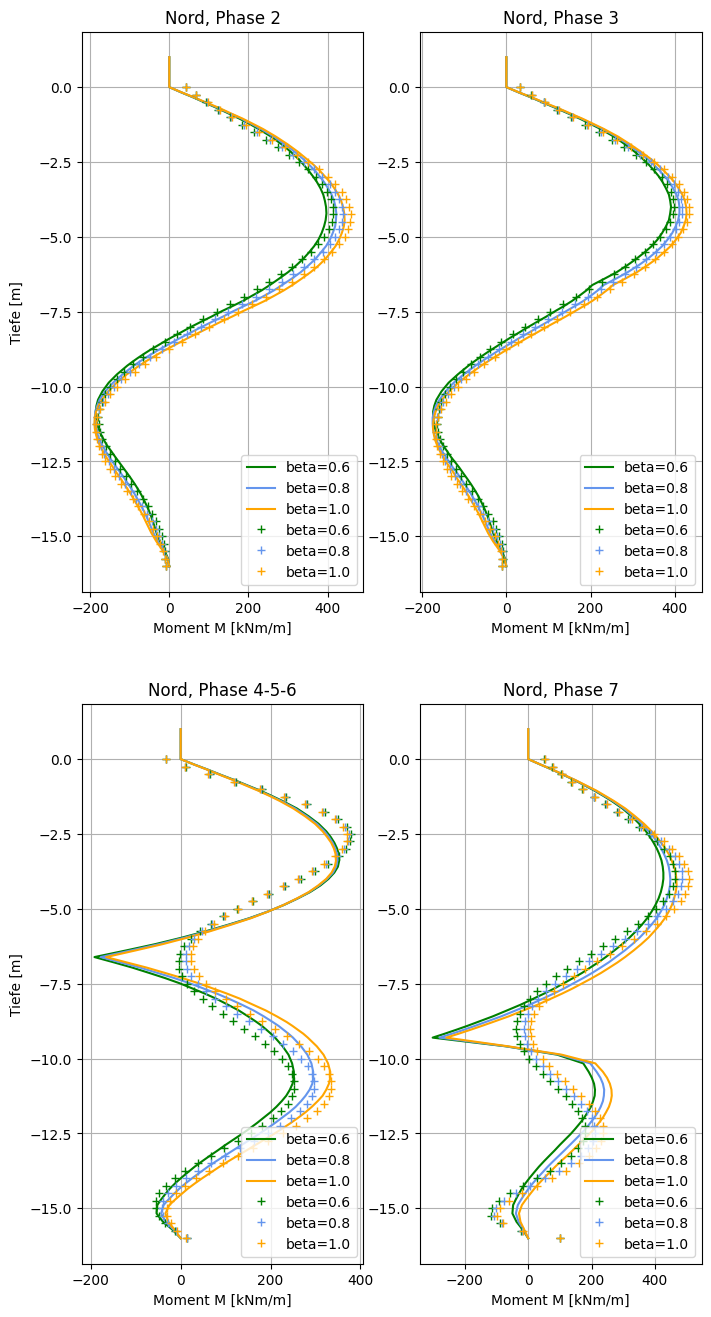

In [43]:
# Comparison of the moments obtined from Plaxis (continuous line) with the interpolated moments (cross)
# North

plt.figure(figsize=(8,16))

plt.subplot(2,2,1)
plt.title('Nord, Phase 2')
plt.plot(df_plaxis_MN['Aushub_Phase2_[kNm/m]_06'], df_plaxis_MN['Y_coordinate_[m]_06'], color='green', linestyle='-', label='beta=0.6')
plt.plot(df_plaxis_MN['Aushub_Phase2_[kNm/m]_08'], df_plaxis_MN['Y_coordinate_[m]_08'], color='cornflowerblue', linestyle='-', label='beta=0.8')
plt.plot(df_plaxis_MN['Aushub_Phase2_[kNm/m]_10'], df_plaxis_MN['Y_coordinate_[m]_10'], color='orange', linestyle='-', label='beta=1.0')
plt.plot(df_BC_N[('Phase 2', 'beta_06', 'moment_M')], df_BC_N.index, color='green', linestyle='', marker='+', label='beta=0.6')
plt.plot(df_BC_N[('Phase 2', 'beta_08', 'moment_M')], df_BC_N.index, color='cornflowerblue', linestyle='', marker='+', label='beta=0.8')
plt.plot(df_BC_N[('Phase 2', 'beta_10', 'moment_M')], df_BC_N.index, color='orange', linestyle='', marker='+', label='beta=1.0')
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Moment M [kNm/m]')
plt.ylabel('Tiefe [m]')
plt.legend()

plt.subplot(2,2,2)
plt.title('Nord, Phase 3')
plt.plot(df_plaxis_MN['untere_Spriesse_Phase3_[kNm/m]_06'], df_plaxis_MN['Y_coordinate_[m]_06'], color='green', linestyle='-', label='beta=0.6')
plt.plot(df_plaxis_MN['untere_Spriesse_Phase3_[kNm/m]_08'], df_plaxis_MN['Y_coordinate_[m]_08'], color='cornflowerblue', linestyle='-', label='beta=0.8')
plt.plot(df_plaxis_MN['untere_Spriesse_Phase3_[kNm/m]_10'], df_plaxis_MN['Y_coordinate_[m]_10'], color='orange', linestyle='-', label='beta=1.0')
plt.plot(df_BC_N[('Phase 3', 'beta_06', 'moment_M')], df_BC_N.index, color='green', linestyle='', marker='+', label='beta=0.6')
plt.plot(df_BC_N[('Phase 3', 'beta_08', 'moment_M')], df_BC_N.index, color='cornflowerblue', linestyle='', marker='+', label='beta=0.8')
plt.plot(df_BC_N[('Phase 3', 'beta_10', 'moment_M')], df_BC_N.index, color='orange', linestyle='', marker='+', label='beta=1.0')
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Moment M [kNm/m]')
plt.legend()

plt.subplot(2,2,3)
plt.title('Nord, Phase 4-5-6')
plt.plot(df_plaxis_MN['Aushub_Phase4_[kNm/m]_06'], df_plaxis_MN['Y_coordinate_[m]_06'], color='green', linestyle='-', label='beta=0.6')
plt.plot(df_plaxis_MN['Aushub_Phase4_[kNm/m]_08'], df_plaxis_MN['Y_coordinate_[m]_08'], color='cornflowerblue', linestyle='-', label='beta=0.8')
plt.plot(df_plaxis_MN['Aushub_Phase4_[kNm/m]_10'], df_plaxis_MN['Y_coordinate_[m]_10'], color='orange', linestyle='-', label='beta=1.0')
plt.plot(df_BC_N[('Phase 4-5-6', 'beta_06', 'moment_M')], df_BC_N.index, color='green', linestyle='', marker='+', label='beta=0.6')
plt.plot(df_BC_N[('Phase 4-5-6', 'beta_08', 'moment_M')], df_BC_N.index, color='cornflowerblue', linestyle='', marker='+', label='beta=0.8')
plt.plot(df_BC_N[('Phase 4-5-6', 'beta_10', 'moment_M')], df_BC_N.index, color='orange', linestyle='', marker='+', label='beta=1.0')
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Moment M [kNm/m]')
plt.ylabel('Tiefe [m]')
plt.legend()

plt.subplot(2,2,4)
plt.title('Nord, Phase 7')
plt.plot(df_plaxis_MN['Rückbau_Spriesse_Phase7_[kNm/m]_06'], df_plaxis_MN['Y_coordinate_[m]_06'], color='green', linestyle='-', label='beta=0.6')
plt.plot(df_plaxis_MN['Rückbau_Spriesse_Phase7_[kNm/m]_08'], df_plaxis_MN['Y_coordinate_[m]_08'], color='cornflowerblue', linestyle='-', label='beta=0.8')
plt.plot(df_plaxis_MN['Rückbau_Spriesse_Phase7_[kNm/m]_10'], df_plaxis_MN['Y_coordinate_[m]_10'], color='orange', linestyle='-', label='beta=1.0')
plt.plot(df_BC_N[('Phase 7', 'beta_06', 'moment_M')], df_BC_N.index, color='green', linestyle='', marker='+', label='beta=0.6')
plt.plot(df_BC_N[('Phase 7', 'beta_08', 'moment_M')], df_BC_N.index, color='cornflowerblue', linestyle='', marker='+', label='beta=0.8')
plt.plot(df_BC_N[('Phase 7', 'beta_10', 'moment_M')], df_BC_N.index, color='orange', linestyle='', marker='+', label='beta=1.0')
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Moment M [kNm/m]')
plt.legend()

plt.show()

In [44]:
# Let's back calculate the reduction factor beta.

# stiffness for a continuous sheet pile wall of VL607-profiles, according to Stabau GmbH, in [kNm2/m]
EI_continuous = 153930

my_dict_N = {'Phase 2': 'w2_N2',
           'Phase 3': 'w2_N3',
           'Phase 4-5-6': 'w2_N456',
           'Phase 7': 'w2_N7'}

for my_phase in my_dict_N:

  # the two dataframes work with different indeces:
  # df_BC_N: 0.00, -0.25, -0.50, ...
  # df_fit_inclino: 0, 1, 2, ...
  i = 0

  # curvature of wall deflection for a given phase
  col_name = my_dict_N[my_phase]

  for index, row in df_BC_N.iterrows():
    # EI = -M / w2
    df_BC_N.at[index, (my_phase, 'beta_06', 'stiffness_EI')] = -df_BC_N.at[index, (my_phase, 'beta_06', 'moment_M')] / df_fit_inclino.at[i, col_name]
    df_BC_N.at[index, (my_phase, 'beta_08', 'stiffness_EI')] = -df_BC_N.at[index, (my_phase, 'beta_08', 'moment_M')] / df_fit_inclino.at[i, col_name]
    df_BC_N.at[index, (my_phase, 'beta_10', 'stiffness_EI')] = -df_BC_N.at[index, (my_phase, 'beta_10', 'moment_M')] / df_fit_inclino.at[i, col_name]

    # beta = EI / EI_continuous
    df_BC_N.at[index, (my_phase, 'beta_06', 'beta')] = df_BC_N.at[index, (my_phase, 'beta_06', 'stiffness_EI')] / EI_continuous
    df_BC_N.at[index, (my_phase, 'beta_08', 'beta')] = df_BC_N.at[index, (my_phase, 'beta_08', 'stiffness_EI')] / EI_continuous
    df_BC_N.at[index, (my_phase, 'beta_10', 'beta')] = df_BC_N.at[index, (my_phase, 'beta_10', 'stiffness_EI')] / EI_continuous

    i += 1

df_BC_N

phase                Phase 2                                       \
reduction factor     beta_06                              beta_08   
back calculation    moment_M   stiffness_EI      beta    moment_M   
 0.00              42.150093            NaN       NaN   42.292161   
-0.25              66.633031            NaN       NaN   67.470707   
-0.50              93.569174   27043.577621  0.175688   95.323832   
-0.75             122.409106   74831.376408  0.486139  125.262758   
-1.00             152.563598  241778.518279  1.570704  156.665345   
...                      ...            ...       ...         ...   
-15.00            -18.713770   26543.996238  0.172442  -25.422138   
-15.25            -14.356730   22285.282281  0.144775  -18.888316   
-15.50            -11.602185   24958.342762  0.162141  -14.133098   
-15.75            -10.007831            NaN       NaN  -10.917146   
-16.00             -8.892574            NaN       NaN   -8.802324   

phase                                                                 \
reduction factor                              beta_10                  
back calculation   stiffness_EI      beta    moment_M   stiffness_EI   
 0.00                       NaN       NaN   42.503917            NaN   
-0.25                       NaN       NaN   68.145322            NaN   
-0.50              27550.712850  0.178982   96.625316   27926.870766   
-0.75              76575.876473  0.497472  127.340698   77846.167215   
-1.00             248278.851732  1.612933  159.654859  253016.550806   
...                         ...       ...         ...            ...   
-15.00             36059.283415  0.234258  -30.230339   42879.334735   
-15.25             29319.451859  0.190473  -22.310174   34631.042679   
-15.50             30402.781609  0.197510  -16.170054   34784.632662   
-15.75                      NaN       NaN  -11.662008            NaN   
-16.00                      NaN       NaN   -8.456913            NaN   

phase                          Phase 3  ... Phase 4-5-6     Phase 7  \
reduction factor               beta_06  ...     beta_10     beta_06   
back calculation      beta    moment_M  ...        beta    moment_M   
 0.00                  NaN   33.509883  ...         NaN   50.161574   
-0.25                  NaN   59.555237  ...         NaN   75.402830   
-0.50             0.181426   88.957007  ...    0.119815  104.076618   
-0.75             0.505724  120.591058  ...    0.443974  135.873075   
-1.00             1.643712  153.433458  ...    0.955658  170.214729   
...                    ...         ...  ...         ...         ...   
-15.00            0.278564  -16.265975  ...    0.167935 -114.391879   
-15.25            0.224979  -11.278337  ...    0.080523 -116.392000   
-15.50            0.225977   -8.694648  ...    0.030482  -89.122345   
-15.75                 NaN   -8.664183  ...         NaN  -21.587369   
-16.00                 NaN  -11.254695  ...         NaN   99.249727   

phase                                                                 \
reduction factor                              beta_08                  
back calculation   stiffness_EI      beta    moment_M   stiffness_EI   
 0.00                       NaN       NaN   52.332738            NaN   
-0.25                       NaN       NaN   77.316728            NaN   
-0.50              50343.369240  0.327054  105.688607   51123.112004   
-0.75              83689.852359  0.543688  137.310892   84575.462896   
-1.00             112798.199159  0.732789  171.725679  113799.478131   
...                         ...       ...         ...            ...   
-15.00             69077.123778  0.448757 -101.859052   61509.002122   
-15.25            204691.531438  1.329770 -107.674086  189359.865599   
-15.50            -80732.441731 -0.524475  -83.953213  -76049.928034   
-15.75                      NaN       NaN  -19.345701            NaN   
-16.00                      NaN       NaN   99.629774            NaN   

phase               

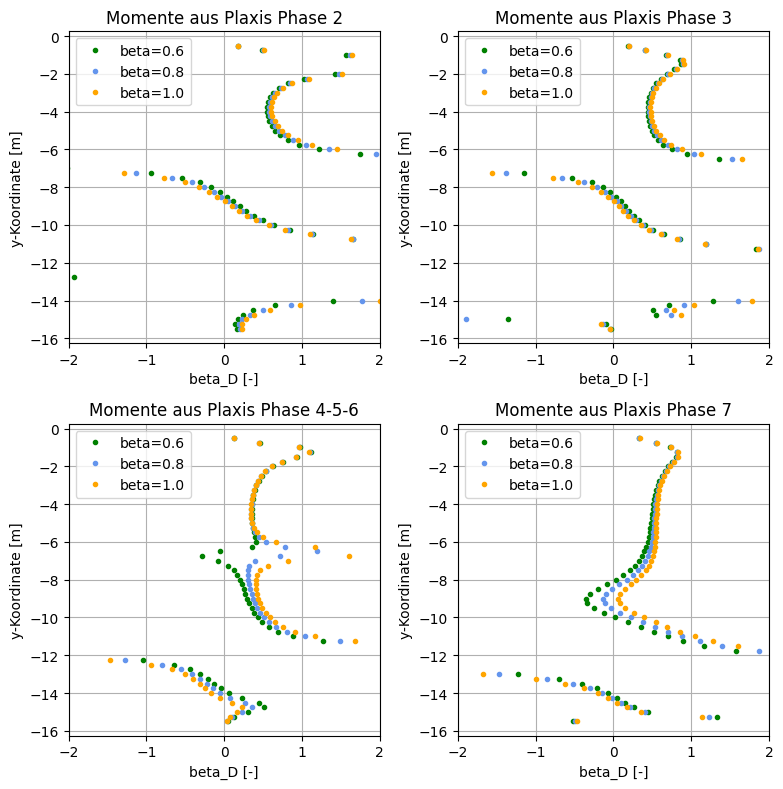

In [45]:
# Let's plot the reduction factor beta.
# North

i=1

plt.figure(figsize=(8,8))

for my_phase in my_dict_N:

  plt.subplot(2,2,i)
  plt.tight_layout()
  plt.title('Momente aus Plaxis ' + my_phase)
  plt.plot(df_BC_N[(my_phase, 'beta_06', 'beta')], df_BC_N.index, color='green', linestyle='', marker='.', label = 'beta=0.6')
  plt.plot(df_BC_N[(my_phase, 'beta_08', 'beta')], df_BC_N.index, color='cornflowerblue', linestyle='', marker='.', label = 'beta=0.8')
  plt.plot(df_BC_N[(my_phase, 'beta_10', 'beta')], df_BC_N.index, color='orange', linestyle='', marker='.', label='beta=1.0')
  plt.xlim(-2, 2)
  plt.grid(visible=True, which='major', axis='both')
  plt.xlabel('beta_D [-]')
  plt.ylabel('y-Koordinate [m]')
  plt.legend()

  i+=1

plt.show()

In [46]:
# Let's save the back calculated beta in a multi-index dataframe called df_beta_summary

#Retaining_wall = ['North', 'South']
#Phase = ['Phase 2', 'Phase 3', 'Phase 4-5-6', 'Phase 7']
#reduction_factor = ['beta_06', 'beta_08', 'beta_10']

my_index = pd.MultiIndex.from_product([Retaining_wall, Phase], names=['Retaining_wall', 'Phase'])
df_beta_summary = pd.DataFrame(np.zeros([8, 3]), index=my_index, columns = reduction_factor)

#df_beta_summary

In [47]:
# Calculate the average beta at a given depth.
# Between 3 m and 5 m the values for beta are stable.

for my_phase in my_dict_N:
  df_beta_summary.loc[('North', my_phase), 'beta_06'] = round(df_BC_N.loc[-3:-5 , (my_phase, 'beta_06', 'beta')].mean(), 3)
  df_beta_summary.loc[('North', my_phase), 'beta_08'] = round(df_BC_N.loc[-3:-5 , (my_phase, 'beta_08', 'beta')].mean(), 3)
  df_beta_summary.loc[('North', my_phase), 'beta_10'] = round(df_BC_N.loc[-3:-5 , (my_phase, 'beta_10', 'beta')].mean(), 3)

#df_beta_summary

## Spundwand Süd

In [48]:
# Fit a polynom of 7th degree to the moments (obtained from Plaxis).
# Save the coefficients in the dataframe df_coeff_moment (already created).

# Sheet pile wall South

df_coeff_moment.loc[('South', 'Phase 2', 'beta_06'), :] = np.polyfit(df_plaxis_MS['Y_coordinate_[m]_06'], df_plaxis_MS['Aushub_Phase2_[kNm/m]_06'], 7)
df_coeff_moment.loc[('South', 'Phase 2', 'beta_08'), :] = np.polyfit(df_plaxis_MS['Y_coordinate_[m]_08'], df_plaxis_MS['Aushub_Phase2_[kNm/m]_08'], 7)
df_coeff_moment.loc[('South', 'Phase 2', 'beta_10'), :] = np.polyfit(df_plaxis_MS['Y_coordinate_[m]_10'], df_plaxis_MS['Aushub_Phase2_[kNm/m]_10'], 7)
df_coeff_moment.loc[('South', 'Phase 3', 'beta_06'), :] = np.polyfit(df_plaxis_MS['Y_coordinate_[m]_06'], df_plaxis_MS['untere_Spriesse_Phase3_[kNm/m]_06'], 7)
df_coeff_moment.loc[('South', 'Phase 3', 'beta_08'), :] = np.polyfit(df_plaxis_MS['Y_coordinate_[m]_08'], df_plaxis_MS['untere_Spriesse_Phase3_[kNm/m]_08'], 7)
df_coeff_moment.loc[('South', 'Phase 3', 'beta_10'), :] = np.polyfit(df_plaxis_MS['Y_coordinate_[m]_10'], df_plaxis_MS['untere_Spriesse_Phase3_[kNm/m]_10'], 7)
df_coeff_moment.loc[('South', 'Phase 4-5-6', 'beta_06'), :] = np.polyfit(df_plaxis_MS['Y_coordinate_[m]_06'], df_plaxis_MS['Aushub_Phase4_[kNm/m]_06'], 7)
df_coeff_moment.loc[('South', 'Phase 4-5-6', 'beta_08'), :] = np.polyfit(df_plaxis_MS['Y_coordinate_[m]_08'], df_plaxis_MS['Aushub_Phase4_[kNm/m]_08'], 7)
df_coeff_moment.loc[('South', 'Phase 4-5-6', 'beta_10'), :] = np.polyfit(df_plaxis_MS['Y_coordinate_[m]_10'], df_plaxis_MS['Aushub_Phase4_[kNm/m]_10'], 7)
df_coeff_moment.loc[('South', 'Phase 7', 'beta_06'), :] = np.polyfit(df_plaxis_MS['Y_coordinate_[m]_06'], df_plaxis_MS['Rückbau_Spriesse_Phase7_[kNm/m]_06'], 7)
df_coeff_moment.loc[('South', 'Phase 7', 'beta_08'), :] = np.polyfit(df_plaxis_MS['Y_coordinate_[m]_08'], df_plaxis_MS['Rückbau_Spriesse_Phase7_[kNm/m]_08'], 7)
df_coeff_moment.loc[('South', 'Phase 7', 'beta_10'), :] = np.polyfit(df_plaxis_MS['Y_coordinate_[m]_10'], df_plaxis_MS['Rückbau_Spriesse_Phase7_[kNm/m]_10'], 7)

df_coeff_moment

a7        a6        a5  \
Retaining_wall Phase       Reduction_factor                                 
North          Phase 2     beta_06          -0.000244 -0.012108 -0.197501   
                           beta_08          -0.000223 -0.011231 -0.184070   
                           beta_10          -0.000217 -0.011020 -0.182348   
               Phase 3     beta_06          -0.000076 -0.002816 -0.001087   
                           beta_08          -0.000048 -0.001495  0.022052   
                           beta_10          -0.000038 -0.001075  0.028729   
               Phase 4-5-6 beta_06           0.001149  0.069913  1.630305   
                           beta_08           0.001173  0.071196  1.654747   
                           beta_10           0.001189  0.072046  1.670695   
               Phase 7     beta_06          -0.001154 -0.051768 -0.806544   
                           beta_08          -0.001235 -0.056023 -0.890661   
                           beta_10          -0.001296 -0.059258 -0.955050   
South          Phase 2     beta_06          -0.000396 -0.019157 -0.315533   
                           beta_08          -0.000383 -0.018727 -0.312574   
                           beta_10          -0.000382 -0.018821 -0.317916   
               Phase 3     beta_06          -0.000225 -0.009670 -0.114967   
                           beta_08          -0.000203 -0.008752 -0.101196   
                           beta_10          -0.000199 -0.008640 -0.101989   
               Phase 4-5-6 beta_06           0.001169  0.070089  1.616856   
                           beta_08           0.001190  0.071233  1.639732   
                           beta_10           0.001199  0.071739  1.649404   
               Phase 7     beta_06          -0.001070 -0.048506 -0.765836   
                           beta_08          -0.001160 -0.053195 -0.857679   
                           beta_10          -0.001220 -0.056376 -0.920791   

                                                    a4         a3          a2  \
Retaining_wall Phase       Reduction_factor                                     
North          Phase 2     beta_06           -0.870544   4.846493   23.596541   
                           beta_08           -0.771625   5.394938   25.738625   
                           beta_10           -0.768643   5.550859   27.166724   
               Phase 3     beta_06            1.077089  13.604203   36.583323   
                           beta_08            1.271265  14.534329   39.064050   
                           beta_10            1.325406  14.895199   40.660081   
               Phase 4-5-6 beta_06           17.976007  91.150714  148.724144   
                           beta_08           18.167004  91.611193  148.793799   
                           beta_10           18.284809  91.822508  148.649423   
               Phase 7     beta_06           -4.666883  -2.506339   27.439430   
                           beta_08           -5.423582  -5.354533   25.257996   
                           beta_10           -6.003978  -7.512662   23.806505   
South          Phase 2     beta_06           -1.739662   2.072200   20.320183   
                           beta_08           -1.753520   2.066478   21.504526   
                           beta_10           -1.824430   1.886132   22.489646   
               Phase 3     beta_06            0.249699  11.018258   33.513113   
                           beta_08            0.344192  11.462956   35.136569   
                           beta_10            0.316246  11.423219   36.079191   
               Phase 4-5-6 beta_06           17.715978  89.640922  145.563205   
                           beta_08           17.905903  90.164588  145.741559   
                           beta_10           17.972641  90.208050  145.431875   
               Phase 7     beta_06           -4.517882  -2.908934   24.175393   
                           beta_08           -5.334374  -5.930982   21.856924   
                       

In [49]:
# Sheet pile wall South
# Let's construct a multi-index dataframe where we are going to save all of our calculation results.

Phase = ['Phase 2', 'Phase 3', 'Phase 4-5-6', 'Phase 7']
reduction_factor = ['beta_06', 'beta_08', 'beta_10']   # these are the reduction factors used in the Plaxis simulations
Y_coord = Y_coord
back_calculation = ['moment_M', 'stiffness_EI', 'beta'] # we aim at back calculationg beta

my_index = pd.MultiIndex.from_product([Phase, reduction_factor, back_calculation], names=['phase', 'reduction factor', 'back calculation'])

# BC means back calculation
# S means South

df_BC_S = pd.DataFrame(np.zeros([36, 65]), index=my_index, columns = Y_coord)
df_BC_S = df_BC_S.T
#df_BC_S

In [50]:
# interpolation of the moment obtained with Plaxis-2D by a polynomial
# South

df_BC_S.loc[:, ('Phase 2', 'beta_06', 'moment_M')] = np.polyval(df_coeff_moment.loc[('South', 'Phase 2', 'beta_06'), :], Y_coord)
df_BC_S.loc[:, ('Phase 2', 'beta_08', 'moment_M')] = np.polyval(df_coeff_moment.loc[('South', 'Phase 2', 'beta_08'), :], Y_coord)
df_BC_S.loc[:, ('Phase 2', 'beta_10', 'moment_M')] = np.polyval(df_coeff_moment.loc[('South', 'Phase 2', 'beta_10'), :], Y_coord)

df_BC_S.loc[:, ('Phase 3', 'beta_06', 'moment_M')] = np.polyval(df_coeff_moment.loc[('South', 'Phase 3', 'beta_06'), :], Y_coord)
df_BC_S.loc[:, ('Phase 3', 'beta_08', 'moment_M')] = np.polyval(df_coeff_moment.loc[('South', 'Phase 3', 'beta_08'), :], Y_coord)
df_BC_S.loc[:, ('Phase 3', 'beta_10', 'moment_M')] = np.polyval(df_coeff_moment.loc[('South', 'Phase 3', 'beta_10'), :], Y_coord)

df_BC_S.loc[:, ('Phase 4-5-6', 'beta_06', 'moment_M')] = np.polyval(df_coeff_moment.loc[('South', 'Phase 4-5-6', 'beta_06'), :], Y_coord)
df_BC_S.loc[:, ('Phase 4-5-6', 'beta_08', 'moment_M')] = np.polyval(df_coeff_moment.loc[('South', 'Phase 4-5-6', 'beta_08'), :], Y_coord)
df_BC_S.loc[:, ('Phase 4-5-6', 'beta_10', 'moment_M')] = np.polyval(df_coeff_moment.loc[('South', 'Phase 4-5-6', 'beta_10'), :], Y_coord)

df_BC_S.loc[:, ('Phase 7', 'beta_06', 'moment_M')] = np.polyval(df_coeff_moment.loc[('South', 'Phase 7', 'beta_06'), :], Y_coord)
df_BC_S.loc[:, ('Phase 7', 'beta_08', 'moment_M')] = np.polyval(df_coeff_moment.loc[('South', 'Phase 7', 'beta_08'), :], Y_coord)
df_BC_S.loc[:, ('Phase 7', 'beta_10', 'moment_M')] = np.polyval(df_coeff_moment.loc[('South', 'Phase 7', 'beta_10'), :], Y_coord)

#df_BC_S

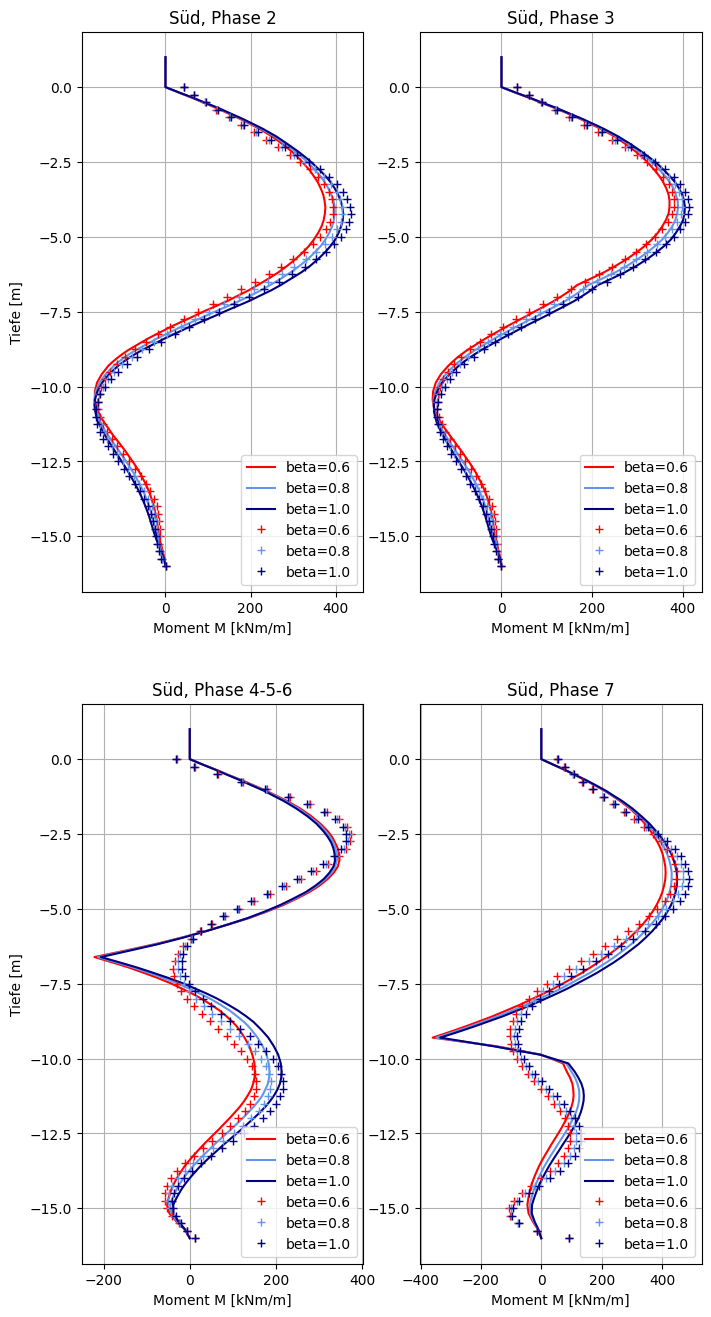

In [51]:
# Comparison of the moments obtined from Plaxis (continuous line) with the interpolated moments (cross)
# South

plt.figure(figsize=(8,16))

plt.subplot(2,2,1)
plt.title('Süd, Phase 2')
plt.plot(df_plaxis_MS['Aushub_Phase2_[kNm/m]_06'], df_plaxis_MS['Y_coordinate_[m]_06'], color='red', linestyle='-', label='beta=0.6')
plt.plot(df_plaxis_MS['Aushub_Phase2_[kNm/m]_08'], df_plaxis_MS['Y_coordinate_[m]_08'], color='cornflowerblue', linestyle='-', label='beta=0.8')
plt.plot(df_plaxis_MS['Aushub_Phase2_[kNm/m]_10'], df_plaxis_MS['Y_coordinate_[m]_10'], color='navy', linestyle='-', label='beta=1.0')
plt.plot(df_BC_S[('Phase 2', 'beta_06', 'moment_M')], df_BC_S.index, color='red', linestyle='', marker='+', label='beta=0.6')
plt.plot(df_BC_S[('Phase 2', 'beta_08', 'moment_M')], df_BC_S.index, color='cornflowerblue', linestyle='', marker='+', label='beta=0.8')
plt.plot(df_BC_S[('Phase 2', 'beta_10', 'moment_M')], df_BC_S.index, color='navy', linestyle='', marker='+', label='beta=1.0')
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Moment M [kNm/m]')
plt.ylabel('Tiefe [m]')
plt.legend()

plt.subplot(2,2,2)
plt.title('Süd, Phase 3')
plt.plot(df_plaxis_MS['untere_Spriesse_Phase3_[kNm/m]_06'], df_plaxis_MS['Y_coordinate_[m]_06'], color='red', linestyle='-', label='beta=0.6')
plt.plot(df_plaxis_MS['untere_Spriesse_Phase3_[kNm/m]_08'], df_plaxis_MS['Y_coordinate_[m]_08'], color='cornflowerblue', linestyle='-', label='beta=0.8')
plt.plot(df_plaxis_MS['untere_Spriesse_Phase3_[kNm/m]_10'], df_plaxis_MS['Y_coordinate_[m]_10'], color='navy', linestyle='-', label='beta=1.0')
plt.plot(df_BC_S[('Phase 3', 'beta_06', 'moment_M')], df_BC_S.index, color='red', linestyle='', marker='+', label='beta=0.6')
plt.plot(df_BC_S[('Phase 3', 'beta_08', 'moment_M')], df_BC_S.index, color='cornflowerblue', linestyle='', marker='+', label='beta=0.8')
plt.plot(df_BC_S[('Phase 3', 'beta_10', 'moment_M')], df_BC_S.index, color='navy', linestyle='', marker='+', label='beta=1.0')
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Moment M [kNm/m]')
plt.legend()

plt.subplot(2,2,3)
plt.title('Süd, Phase 4-5-6')
plt.plot(df_plaxis_MS['Aushub_Phase4_[kNm/m]_06'], df_plaxis_MS['Y_coordinate_[m]_06'], color='red', linestyle='-', label='beta=0.6')
plt.plot(df_plaxis_MS['Aushub_Phase4_[kNm/m]_08'], df_plaxis_MS['Y_coordinate_[m]_08'], color='cornflowerblue', linestyle='-', label='beta=0.8')
plt.plot(df_plaxis_MS['Aushub_Phase4_[kNm/m]_10'], df_plaxis_MS['Y_coordinate_[m]_10'], color='navy', linestyle='-', label='beta=1.0')
plt.plot(df_BC_S[('Phase 4-5-6', 'beta_06', 'moment_M')], df_BC_S.index, color='red', linestyle='', marker='+', label='beta=0.6')
plt.plot(df_BC_S[('Phase 4-5-6', 'beta_08', 'moment_M')], df_BC_S.index, color='cornflowerblue', linestyle='', marker='+', label='beta=0.8')
plt.plot(df_BC_S[('Phase 4-5-6', 'beta_10', 'moment_M')], df_BC_S.index, color='navy', linestyle='', marker='+', label='beta=1.0')
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Moment M [kNm/m]')
plt.ylabel('Tiefe [m]')
plt.legend()

plt.subplot(2,2,4)
plt.title('Süd, Phase 7')
plt.plot(df_plaxis_MS['Rückbau_Spriesse_Phase7_[kNm/m]_06'], df_plaxis_MS['Y_coordinate_[m]_06'], color='red', linestyle='-', label='beta=0.6')
plt.plot(df_plaxis_MS['Rückbau_Spriesse_Phase7_[kNm/m]_08'], df_plaxis_MS['Y_coordinate_[m]_08'], color='cornflowerblue', linestyle='-', label='beta=0.8')
plt.plot(df_plaxis_MS['Rückbau_Spriesse_Phase7_[kNm/m]_10'], df_plaxis_MS['Y_coordinate_[m]_10'], color='navy', linestyle='-', label='beta=1.0')
plt.plot(df_BC_S[('Phase 7', 'beta_06', 'moment_M')], df_BC_S.index, color='red', linestyle='', marker='+', label='beta=0.6')
plt.plot(df_BC_S[('Phase 7', 'beta_08', 'moment_M')], df_BC_S.index, color='cornflowerblue', linestyle='', marker='+', label='beta=0.8')
plt.plot(df_BC_S[('Phase 7', 'beta_10', 'moment_M')], df_BC_S.index, color='navy', linestyle='', marker='+', label='beta=1.0')
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Moment M [kNm/m]')
plt.legend()

plt.show()

In [52]:
# Let's back calculate the reduction factor beta.

# stiffness for a continuous sheet pile wall of VL607-profiles, according to Stabau GmbH, in [kNm2/m]
EI_continuous = 153930

my_dict_S = {'Phase 2': 'w2_S2',
           'Phase 3': 'w2_S3',
           'Phase 4-5-6': 'w2_S456',
           'Phase 7': 'w2_S7'}

for my_phase in my_dict_S:

  # the two dataframes work with different indeces:
  # df_BC_S: 0.00, -0.25, -0.50, ...
  # df_fit_inclino: 0, 1, 2, ...
  i = 0

  # curvature of wall deflection for a given phase
  col_name = my_dict_S[my_phase]

  for index, row in df_BC_S.iterrows():
    # EI = -M / w2
    df_BC_S.at[index, (my_phase, 'beta_06', 'stiffness_EI')] = -df_BC_S.at[index, (my_phase, 'beta_06', 'moment_M')] / df_fit_inclino.at[i, col_name]
    df_BC_S.at[index, (my_phase, 'beta_08', 'stiffness_EI')] = -df_BC_S.at[index, (my_phase, 'beta_08', 'moment_M')] / df_fit_inclino.at[i, col_name]
    df_BC_S.at[index, (my_phase, 'beta_10', 'stiffness_EI')] = -df_BC_S.at[index, (my_phase, 'beta_10', 'moment_M')] / df_fit_inclino.at[i, col_name]

    # beta = EI / EI_continuous
    df_BC_S.at[index, (my_phase, 'beta_06', 'beta')] = df_BC_S.at[index, (my_phase, 'beta_06', 'stiffness_EI')] / EI_continuous
    df_BC_S.at[index, (my_phase, 'beta_08', 'beta')] = df_BC_S.at[index, (my_phase, 'beta_08', 'stiffness_EI')] / EI_continuous
    df_BC_S.at[index, (my_phase, 'beta_10', 'beta')] = df_BC_S.at[index, (my_phase, 'beta_10', 'stiffness_EI')] / EI_continuous

    i += 1

df_BC_S

phase                Phase 2                                      \
reduction factor     beta_06                             beta_08   
back calculation    moment_M  stiffness_EI      beta    moment_M   
 0.00              43.253285           NaN       NaN   43.731711   
-0.25              66.545178           NaN       NaN   67.514672   
-0.50              92.096645   7705.247979  0.050057   93.704948   
-0.75             119.512516  14838.290816  0.096396  121.905577   
-1.00             148.301387  28253.411554  0.183547  151.621532   
...                      ...           ...       ...         ...   
-15.00            -13.947145  -7703.941930 -0.050048  -17.861808   
-15.25            -14.106668  -4467.952686 -0.029026  -16.404387   
-15.50            -12.808009  -2563.017016 -0.016651  -13.950287   
-15.75             -8.223839           NaN       NaN   -8.909442   
-16.00              1.973559           NaN       NaN    0.768940   

phase                                                                         \
reduction factor                             beta_10                           
back calculation  stiffness_EI      beta    moment_M  stiffness_EI      beta   
 0.00                      NaN       NaN   43.970421           NaN       NaN   
-0.25                      NaN       NaN   68.037725           NaN       NaN   
-0.50              7839.806283  0.050931   94.648668   7918.762432  0.051444   
-0.75             15135.405633  0.098327  123.413995  15322.685912  0.099543   
-1.00             28885.943756  0.187656  153.840950  29308.772824  0.190403   
...                        ...       ...         ...           ...       ...   
-15.00            -9866.272248 -0.064096  -21.846482 -12067.274387 -0.078395   
-15.25            -5195.700705 -0.033754  -19.097103  -6048.554474 -0.039294   
-15.50            -2791.598836 -0.018136  -15.488957  -3099.502848 -0.020136   
-15.75                     NaN       NaN   -9.540300           NaN       NaN   
-16.00                     NaN       NaN    0.674488           NaN       NaN   

phase                Phase 3  ... Phase 4-5-6     Phase 7                \
reduction factor     beta_06  ...     beta_10     beta_06                 
back calculation    moment_M  ...        beta    moment_M  stiffness_EI   
 0.00              34.759424  ...         NaN   51.515142           NaN   
-0.25              59.761747  ...         NaN   76.563522           NaN   
-0.50              87.937127  ...    0.022240  104.681177   5543.429472   
-0.75             118.303306  ...    0.061409  135.611399  10071.104118   
-1.00             149.924815  ...    0.132560  168.835497  17990.539883   
...                      ...  ...         ...         ...           ...   
-15.00            -11.425797  ...   -0.095450 -105.448851 -26578.539453   
-15.25            -10.944136  ...   -0.050235 -103.661341 -14756.725162   
-15.50             -9.836086  ...   -0.022256  -76.911385  -6860.590729   
-15.75             -6.881104  ...         NaN  -15.556370           NaN   
-16.00             -0.519076  ...         NaN   91.877768           NaN   

phase                                                                       \
reduction factor               beta_08                             beta_10   
back calculation      beta    moment_M  stiffness_EI      beta    moment_M   
 0.00                  NaN   53.793602           NaN       NaN   55.261956   
-0.25                  NaN   78.543598           NaN       NaN   79.876490   
-0.50             0.036013  106.314347   5629.914592  0.036575  107.509440   
-0.75             0.065427  137.030483  10176.491578  0.066111  138.208753   
-1.00             0.116875  170.297897  18146.368322  0.117887  171.664249   
...                    ...         ...           ...       ...         ...   
-15.00           -0.172666  -99.533391 -25087.538849 -0.162980  -93.120415   
-15.25           -0.095866 -100.350169 -14285.362801 -0.092804  -96.162713   
-15.50           

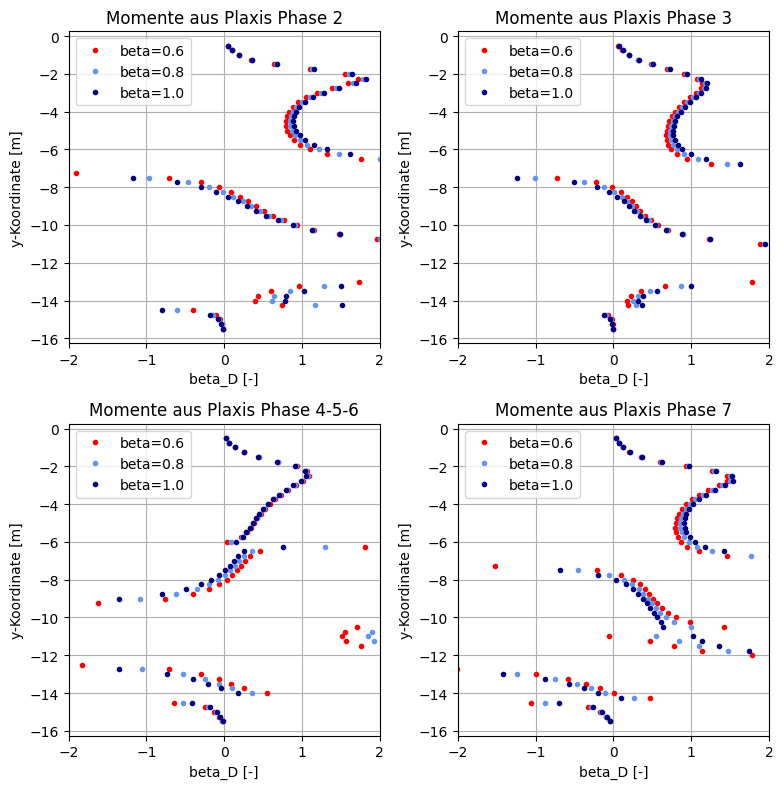

In [53]:
# Let's plot the reduction factor beta.
# South

i=1

plt.figure(figsize=(8,8))

for my_phase in my_dict_S:

  plt.subplot(2,2,i)
  plt.tight_layout()
  plt.title('Momente aus Plaxis ' + my_phase)
  plt.plot(df_BC_S[(my_phase, 'beta_06', 'beta')], df_BC_S.index, color='red', linestyle='', marker='.', label = 'beta=0.6')
  plt.plot(df_BC_S[(my_phase, 'beta_08', 'beta')], df_BC_S.index, color='cornflowerblue', linestyle='', marker='.', label = 'beta=0.8')
  plt.plot(df_BC_S[(my_phase, 'beta_10', 'beta')], df_BC_S.index, color='navy', linestyle='', marker='.', label='beta=1.0')
  plt.xlim(-2, 2)
  plt.grid(visible=True, which='major', axis='both')
  plt.xlabel('beta_D [-]')
  plt.ylabel('y-Koordinate [m]')
  plt.legend()

  i+=1

plt.show()

In [54]:
# Calculate the average beta at a given depth.
# Between 4 m and 6 m the values for beta are stable.

for my_phase in my_dict_S:
  df_beta_summary.loc[('South', my_phase), 'beta_06'] = round(df_BC_S.loc[-4:-6 , (my_phase, 'beta_06', 'beta')].mean(), 3)
  df_beta_summary.loc[('South', my_phase), 'beta_08'] = round(df_BC_S.loc[-4:-6 , (my_phase, 'beta_08', 'beta')].mean(), 3)
  df_beta_summary.loc[('South', my_phase), 'beta_10'] = round(df_BC_S.loc[-4:-6 , (my_phase, 'beta_10', 'beta')].mean(), 3)

#df_beta_summary

# Schlussfolgerungen

In [55]:
df_beta_summary

beta_06  beta_08  beta_10
Retaining_wall Phase                                 
North          Phase 2        0.586    0.620    0.648
               Phase 3        0.458    0.481    0.499
               Phase 4-5-6    0.368    0.364    0.362
               Phase 7        0.519    0.546    0.569
South          Phase 2        0.873    0.942    0.999
               Phase 3        0.719    0.769    0.811
               Phase 4-5-6    0.364    0.362    0.365
               Phase 7        0.840    0.905    0.960

Folgende Schlussfolgerungen können anhand der Rückrechnung basierend auf dem Momentenverlauf aus Plaxis-2D gezogen werden:

*   Für eine gegebene Bauphase sind die Abminderungsfaktoren $\beta_D$ der Spundwand Süd deutlich höher als diejenigen der Spundwand Nord. Dies ist zu erwarten: die Inklinometermessungen haben gezeigt, dass die Verformungen auf der südlichen Seite deutlich geringer sind. Eine Ausnahme bilden die Phasen 4, 5 und 6, wobei die Abminderungsfaktoren praktisch identisch sind.

*   Für die Phasen 4, 5 und 6 sind die Werte von $\beta_D$ mit $\sim 0.36$ sehr tief. Dies konnte bereits erahnt werden, siehe Abbildung im Kapitel "Vergleich zwischen Plaxis und Inklinometer": die gemessenen Verformungen der Spundwand Nord sind deutlich höher als diejenigen aus Plaxis. Die Gründe für diese Abweichung konnten nicht abschliessend abgeklärt werden. Wahrscheinlich haben zeitabhängige Effekte (Kriechen, siehe auch Kapitel "Weiteres Vorgehen") eine Rolle gespielt, sowie die Unsicherheiten bei der Wahl des Datums der massgebenden Inklinometermessung.

*   Für die Spundwand Nord schätzen wir den Abminderungsfaktor wie folgt ab: $$\beta_D = 0.45 - 0.65 $$

*   Für die Spundwand Süd schätzen wir den Abminderungsfaktor wie folgt ab: $$\beta_D = 0.75 - 0.95 $$

# Weiteres Vorgehen

## Kriechen: zeitabhängige Verformungen

Ab dem 10.-12. Juni 2020 bleibt das statische System der Spundwand unverändert: Die untere Spriessenlage im Block 52 ist rückgebaut und die Rohbauarbeiten für den Tunnel gehen weiter; die Hinterfüllung erfolgt erst ab dem 18. August 2020.

Die Inklinometermessungen zeigen, dass sich die Spundwand in diesem Zeitraum (10.06.2020 - 18.08.2020) weiter verformt. Woran könnte das liegen? Erstens, der untere Grundwasserspiegel steigt während dieser Zeit um ca. einen halben Meter (siehe RB 16/04 und RB 16/03). Zweitens, es kann sich um zeitabhängige Verformungen handeln, d.h. Kriechen.

Das untenstehende Diagramm zeigt die Verformungen in diesem Zeitraum (die letzte Inklinometermessung wurde am 1. September 2020 durchgeführt).

In [56]:
# select a few dates to show the deformations during this time
dates_timeeffect = ['2020-06-16', '2020-07-17', '2020-08-18', '2020-09-01']

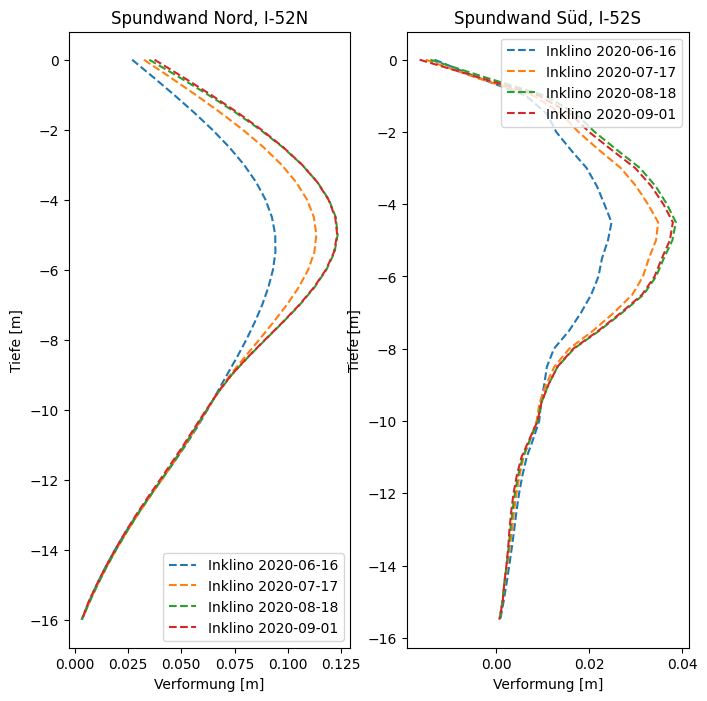

In [57]:
plt.figure(figsize=(8,8))

# I-52N (A)
plt.subplot(1,2,1)
plt.title('Spundwand Nord, I-52N')

for date in dates_timeeffect:
  df_1 = df.loc[(df.index == date) & (df['tube'] == 'I-52N'), :]
  legend_1 = 'Inklino ' + str(date)
  plt.plot(df_1['A_defo_relat'], -df_1['depth']+0.5, linestyle='--', label=legend_1)

plt.xlabel('Verformung [m]')
plt.ylabel('Tiefe [m]')
plt.legend()


# I-52S (A)
plt.subplot(1,2,2)
plt.title('Spundwand Süd, I-52S')

for date in dates_timeeffect:
  df_1 = df.loc[(df.index == date) & (df['tube'] == 'I-52S'), :]
  legend_1 = 'Inklino ' + str(date)
  plt.plot(df_1['A_defo_relat'], -df_1['depth']+0.5, linestyle='--', label=legend_1)

plt.xlabel('Verformung [m]')
plt.ylabel('Tiefe [m]')
plt.legend()
plt.show()

In [58]:
# How much does the deflection increase between 2020-06-16 and 2020-09-01?

# North sheet pile wall
max_north_20200616 = df.loc[(df.index == '2020-06-16') & (df['tube'] == 'I-52N'), :]['A_defo_relat'].max()
max_north_20200901 = df.loc[(df.index == '2020-09-01') & (df['tube'] == 'I-52N'), :]['A_defo_relat'].max()
max_north_delta = max_north_20200901 - max_north_20200616
print('The inflection increases by ' + str(round(max_north_delta, 4)) + ' m')

The inflection increases by 0.029 m


In [59]:
# South sheet pile wall
max_south_20200616 = df.loc[(df.index == '2020-06-16') & (df['tube'] == 'I-52S'), :]['A_defo_relat'].max()
max_south_20200901 = df.loc[(df.index == '2020-09-01') & (df['tube'] == 'I-52S'), :]['A_defo_relat'].max()
max_south_delta = max_south_20200901 - max_south_20200616
print('The inflection increases by ' + str(round(max_south_delta, 4)) + ' m')

The inflection increases by 0.0132 m


Die Plaxis-Simulationen zeigen, dass eine Zunahme des Grundwasserspiegels einen minimalen Einfluss auf die Wandverformungen hat. Wir gehen somit davon aus, dass die Verformungen ab dem 16.06.2020 auf Kriechen zurückzuführen ist.
Die FE-Software Plaxis verfügt über Materialgesetze, womit man das zeitabhängige Verhalten von Böden nachbilden kann. Diese Analyse wird auf einem späteren Zeitpunkt verschoben.